<a href="https://www.kaggle.com/code/jorgemmlrodrigues/walmart-price-pred?scriptVersionId=247661249" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:

#Kaggle
!git -C /kaggle/working clone --depth 1 https://github.com/JorgeMMLRodrigues/ml_walmart_price.git || \
 git -C /kaggle/working/ml_walmart_price pull    
!pip install -q -r /kaggle/working/ml_walmart_price/requirements.txt

import sys, os
os.chdir("/kaggle/working/ml_walmart_price")
sys.path.insert(0, os.getcwd())

In [2]:
import sys, os
from utils.trainer import ModelTrainer

import pandas as pd
import numpy as np
from dotenv import load_dotenv
import random, time, inspect,time,json,os,requests,sys, math
from pathlib import Path

from datetime import date, datetime, timedelta
from dateutil.easter import easter

from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import yfinance as yf

import akshare as ak

from pandas_datareader.data import DataReader
from pandas_datareader import wb

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, roc_auc_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.linear_model import RidgeCV, Lasso,ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit,ParameterGrid,GridSearchCV
import lightgbm as lgb

from sklearn.inspection import PartialDependenceDisplay,permutation_importance
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


c:\Users\estif\Desktop\DataAnalyst\_DataCourse_IronHack\Quests\ml_walmart_price\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# skip cells:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):

    return

# Data

## Data Exploration

In [4]:
%%skip
df_walmart_train = pd.read_csv('csv_files/walmart_data/train.csv')
df_walmart_test = pd.read_csv('csv_files/walmart_data/test.csv')
df_walmart_features = pd.read_csv('csv_files/walmart_data/features.csv')
df_walmart_stores = pd.read_csv('csv_files/walmart_data/stores.csv')

df_walmart_train["Date"] = pd.to_datetime(df_walmart_train["Date"], errors="raise")
df_walmart_test["Date"] = pd.to_datetime(df_walmart_test["Date"], errors="raise")
df_walmart_features["Date"] = pd.to_datetime(df_walmart_features["Date"], errors="raise")

In [5]:
%%skip
df_walmart_train

In [6]:
%%skip
df_walmart_test

In [7]:
%%skip
df_walmart_features


## Data Gathering

#### Sp500

In [8]:
%%skip
# SP500 Index
START_DATE = "2000-01-01"
END_DATE   = date.today().isoformat()


daily = yf.download(
    "^GSPC",           # S&P 500 index ticker
    start=START_DATE,
    end=END_DATE,
    interval="1d",
    auto_adjust=True,
    progress=False,
)

if isinstance(daily.columns, pd.MultiIndex):
    lvl0 = daily.columns.get_level_values(0)
    if "Close" in lvl0:
        close_prices = daily.xs("Close", axis=1, level=0)
    elif "Adj Close" in lvl0:
        close_prices = daily.xs("Adj Close", axis=1, level=0)
    else:
        raise KeyError("Neither 'Close' nor 'Adj Close' found in data")
else:
    if "Close" in daily.columns:
        close_prices = daily["Close"]
    else:
        close_prices = daily["Adj Close"]


weekly_mean_close = close_prices.resample("W-FRI").mean()

if isinstance(weekly_mean_close, pd.Series):
    df_sp500 = weekly_mean_close.to_frame(name="SPX_Weekly_Mean_Close")
else:
    df_sp500 = weekly_mean_close.copy()
    df_sp500.columns = ["SPX_Weekly_Mean_Close"]


OUTFILE = "csv_files/idea_csv/sp500_weekly_mean_close.csv"
df_sp500.to_csv(OUTFILE)



In [9]:
%%skip
df_sp500 = pd.read_csv("csv_files/idea_csv/sp500_weekly_mean_close.csv")
df_sp500

#### Walmart Stock Price

In [10]:
%%skip
START_DATE = "2000-01-01"
END_DATE   = date.today().isoformat()


daily = yf.download(
    "WMT",           
    start=START_DATE,
    end=END_DATE,
    interval="1d",
    auto_adjust=True, 
    progress=False,
)


if isinstance(daily.columns, pd.MultiIndex):
    lvl0 = daily.columns.get_level_values(0)
    if "Close" in lvl0:
        close_prices = daily.xs("Close", axis=1, level=0)
    elif "Adj Close" in lvl0:
        close_prices = daily.xs("Adj Close", axis=1, level=0)
    else:
        raise KeyError("Neither 'Close' nor 'Adj Close' found in data")
else:
    if "Close" in daily.columns:
        close_prices = daily["Close"]
    else:
        close_prices = daily["Adj Close"]


weekly_mean_close = close_prices.resample("W-FRI").mean()


if isinstance(weekly_mean_close, pd.Series):
    df_walmart_stock = weekly_mean_close.to_frame(name="WMT_Weekly_Mean_Close")
else:
    df_walmart_stock = weekly_mean_close.copy()
    df_walmart_stock.columns = ["WMT_Weekly_Mean_Close"]


OUTFILE = "csv_files/idea_csv/wmt_weekly_mean_close.csv"
df_walmart_stock.to_csv(OUTFILE)



In [11]:
df_walmart_stock = pd.read_csv("csv_files/idea_csv/wmt_weekly_mean_close.csv")
df_walmart_stock

,Date,WMT_Weekly_Mean_Close
0,2000-01-07,13.941764
1,2000-01-14,14.021870
2,2000-01-21,13.642020
3,2000-01-28,12.676027
4,2000-02-04,12.240765
...,...,...
1324,2025-05-23,96.924001
1325,2025-05-30,97.660000
1326,2025-06-06,98.906000
1327,2025-06-13,95.968001


#### External Logistic companies Walmart

In [12]:
%%skip
#   - ARCB: ArcBest Corporation (ABF Logistics / ArcBest Freight)
#   - AIT: AIT Worldwide Logistics
#   - CEVA: CEVA Logistics
#   - DPW.DE: Deutsche Post (DHL Freight / DHL Supply Chain) on XETRA
#   - FDX: FedEx Corporation (FedEx Freight)
#   - SAIA: Saia, Inc. (Saia Motor Freight Line)
#   - TFII.TO: TFI International (TForce Freight) on TSX
#   - XPO: XPO Logistics, Inc.
#   - ODFL: Old Dominion Freight Line, Inc.
#   - UPS: United Parcel Service, Inc.
#   - JBHT: J.B. Hunt Transport Services, Inc.
# Note: Some private carriers (Estes Express, R+L Carriers) are not publicly traded.

TICKERS = [
    "ARCB", "AIT", "CEVA", "DPW.DE", "FDX",
    "SAIA", "TFII.TO", "XPO", "ODFL", "UPS", "JBHT"
]

START_DATE = "2000-01-01"
END_DATE   = date.today().isoformat()

daily = yf.download(
    TICKERS,
    start=START_DATE,
    end=END_DATE,
    interval="1d",
    auto_adjust=True,
    group_by="ticker",
    threads=True,
    progress=True,
)

close = pd.DataFrame()
for sym in TICKERS:
    try:
        series = daily[sym]["Close"]
        close[sym] = series
    except Exception:
        print(f"Skipping {sym!r}: no data available or ticker invalid")


before = close.shape[1]
close = close.dropna(axis=1, how="all")
after = close.shape[1]
print(f"Dropped {before-after} tickers; {after} tickers remain for analysis")

df_logistics = close.resample("W-FRI").mean().round(4)

df_logistics.columns = [f"{sym}_df_logistics_Close" for sym in df_logistics.columns]

OUTFILE = "csv_files/idea_csv/logistics_df_logistics_close.csv"
df_logistics.to_csv(OUTFILE)


In [13]:
df_logistics = pd.read_csv("csv_files/idea_csv/logistics_df_logistics_close.csv")
df_logistics

,Date,ARCB_df_logistics_Close,AIT_df_logistics_Close,CEVA_df_logistics_Close,FDX_df_logistics_Close,SAIA_df_logistics_Close,TFII.TO_df_logistics_Close,XPO_df_logistics_Close,ODFL_df_logistics_Close,UPS_df_logistics_Close,JBHT_df_logistics_Close
0,2000-01-07,10.2456,4.2252,NaN,36.1330,NaN,NaN,NaN,0.4840,33.4329,2.6094
1,2000-01-14,10.2209,4.0500,NaN,37.6513,NaN,NaN,NaN,0.4914,33.7016,2.5821
2,2000-01-21,10.6344,4.3393,NaN,35.1930,NaN,NaN,NaN,0.5243,34.1281,2.5124
3,2000-01-28,9.9543,4.2880,NaN,33.1066,NaN,NaN,NaN,0.5354,32.7017,2.4714
4,2000-02-04,9.3568,4.2649,NaN,31.9144,NaN,NaN,NaN,0.5190,29.3584,2.5079
...,...,...,...,...,...,...,...,...,...,...,...
1324,2025-05-23,63.7080,226.5780,20.1420,219.8980,272.0360,121.3875,121.308,165.8267,96.9700,141.4160
1325,2025-05-30,63.9625,227.6050,19.1925,218.8175,269.3875,119.2300,117.125,161.9264,97.4825,139.3725
1326,2025-06-06,63.4820,228.9500,19.8700,218.5800,260.4360,118.7120,115.588,160.7950,97.8220,139.3440
1327,2025-06-13,69.1700,230.5940,21.0920,224.7040,259.1800,123.1960,121.270,162.9600,100.7700,141.6980


#### Official China PMI (Caixin PMI only starts in 2014)


In [14]:
%%skip
# All AkShare functions containing "pmi"

df_official = ak.macro_china_pmi()

print("Columns in df_official:", df_official.columns.tolist())


In [15]:
%%skip
# 1) Fetch the official China PMI data
df_official = ak.macro_china_pmi()

# 2) Rename Chinese column names to English
df_official = df_official.rename(columns={
    "月份": "Date",
    "制造业-指数": "Official_Manufacturing_PMI",
    "制造业-同比增长": "Official_Manufacturing_PMI_YoY",
    "非制造业-指数": "Official_Services_PMI",
    "非制造业-同比增长": "Official_Services_PMI_YoY",
})

# 3) Clean and parse the 'Date' column ("YYYY年MM月份" → "YYYY-MM")
df_official["Date"] = (
    df_official["Date"]
      .str.replace("年", "-", regex=False)
      .str.replace("月份", "", regex=False)
)
df_official["Date"] = pd.to_datetime(df_official["Date"], format="%Y-%m")

# 4) Set Date as the index and sort
df_official = df_official.set_index("Date").sort_index()

# 5) Subset to the period 2009-01-01 through 2014-12-31
df_pmi_china = df_official.loc["2009-01-01":"2014-12-31"]
df_pmi_china.to_csv("csv_files/idea_csv/df_pmi_china.csv")

In [16]:
df_pmi_china = pd.read_csv("csv_files/idea_csv/df_pmi_china.csv")
df_pmi_china

,Date,Official_Manufacturing_PMI,Official_Manufacturing_PMI_YoY,Official_Services_PMI,Official_Services_PMI_YoY
0,2009-01-01,45.3,-14.528302,53.7,-10.797342
1,2009-02-01,49.0,-8.239700,55.1,-7.082631
2,2009-03-01,52.4,-10.273973,54.4,-7.640068
3,2009-04-01,53.5,-9.628378,53.5,-8.390411
4,2009-05-01,53.1,-0.375235,54.9,-4.355401
...,...,...,...,...,...
67,2014-08-01,51.1,0.196078,54.4,0.927644
68,2014-09-01,51.1,0.000000,54.0,-2.527076
69,2014-10-01,50.8,-1.167315,53.8,-4.440497
70,2014-11-01,50.3,-2.140078,53.9,-3.750000


#### PCE USA (Personal Consumption Expenditures)


In [17]:
%%skip
START_DATE = "2000-01-01"
END_DATE   = date.today().isoformat()

df_pce = DataReader("PCE", "fred", start=START_DATE, end=END_DATE)

df_pce.columns = ["Personal_Consumption_Expenditures"]

# 4) Save and quick sanity-check
OUTFILE = "csv_files/idea_csv/personal_consumption_expenditures.csv"
df_pce.to_csv(OUTFILE)


In [18]:
df_pce = pd.read_csv("csv_files/idea_csv/personal_consumption_expenditures.csv")
df_pce

,DATE,Personal_Consumption_Expenditures
0,2000-01-01,6542.9
1,2000-02-01,6625.3
2,2000-03-01,6686.5
3,2000-04-01,6679.1
4,2000-05-01,6709.7
...,...,...
299,2024-12-01,20408.1
300,2025-01-01,20389.0
301,2025-02-01,20469.3
302,2025-03-01,20621.8


#### Interest Rates USA (Fed Funds Rate & Tbill 3 Months Yield)

In [19]:
%%skip
START = "2001-06-01"               
END   = date.today().isoformat()


fed  = DataReader("FEDFUNDS", "fred", START, END)
tbill = DataReader("DGS3MO",  "fred", START, END)

df_interest_rates = pd.concat([fed, tbill], axis=1).rename(columns={
    "FEDFUNDS": "Fed_Funds_Rate",
    "DGS3MO":   "TBill_3mo_Yield",
})
df_interest_rates = df_interest_rates.resample("W-FRI").mean()

OUTFILE = "csv_files/idea_csv/df_interest_rates.csv"
df_interest_rates.to_csv(OUTFILE)

In [20]:
df_interest_rates = pd.read_csv("csv_files/idea_csv/df_interest_rates.csv")
df_interest_rates

,DATE,Fed_Funds_Rate,TBill_3mo_Yield
0,2001-06-01,3.97,3.670
1,2001-06-08,NaN,3.640
2,2001-06-15,NaN,3.558
3,2001-06-22,NaN,3.496
4,2001-06-29,NaN,3.546
...,...,...,...
1250,2025-05-16,NaN,4.398
1251,2025-05-23,NaN,4.372
1252,2025-05-30,NaN,4.355
1253,2025-06-06,NaN,4.436


#### CCI USA (Consumer Confidence Index) from University of Michigan

In [21]:
%%skip
START_DATE = "2001-06-17"
END_DATE   = date.today().isoformat()

df_us_cci = DataReader("UMCSENT", "fred", START_DATE, END_DATE)
df_us_cci.columns = ["Consumer_Sentiment_UMich"]

OUTFILE = "csv_files/idea_csv/consumer_confidence_index.csv"
df_us_cci.to_csv(OUTFILE)

In [22]:
df_us_cci = pd.read_csv("csv_files/idea_csv/consumer_confidence_index.csv")
df_us_cci

,DATE,Consumer_Sentiment_UMich
0,2001-07-01,92.4
1,2001-08-01,91.5
2,2001-09-01,81.8
3,2001-10-01,82.7
4,2001-11-01,83.9
...,...,...
281,2024-12-01,74.0
282,2025-01-01,71.7
283,2025-02-01,64.7
284,2025-03-01,57.0


#### U.S.A Advance Retail Sales: Retail Trade and Food Services

In [23]:
%%skip
START_DATE = "2000-01-01"
END_DATE   = date.today().isoformat()

# RSAFS = Advance Retail Sales: Retail Trade and Food Services (Millions of Dollars, SA)
df_us_retail = DataReader("RSAFS", "fred", START_DATE, END_DATE)

df_us_retail.columns = ["Retail_Sales_Retail_and_Food_Services_USA"]

OUTFILE = "csv_files/idea_csv/usa_retail_sales.csv"
df_us_retail.to_csv(OUTFILE)

In [24]:
df_us_retail = pd.read_csv("csv_files/idea_csv/usa_retail_sales.csv")
df_us_retail

,DATE,Retail_Sales_Retail_and_Food_Services_USA
0,2000-01-01,261545
1,2000-02-01,265686
2,2000-03-01,269019
3,2000-04-01,264067
4,2000-05-01,265992
...,...,...
300,2025-01-01,711461
301,2025-02-01,711757
302,2025-03-01,722572
303,2025-04-01,721983


#### Exchange Rates (China, Mexico, Canada, India, Vietnam)


In [25]:
%%skip
START = "2001-06-17"                 
END   = date.today().isoformat()

#    China (CNY per USD): DEXCHUS  
#    Mexico (MXN per USD): DEXMXUS  
#    Canada (CAD per USD): DEXCAUS  
#    India (INR per USD): DEXINUS  
cny = DataReader("DEXCHUS", "fred", START, END)
mxn = DataReader("DEXMXUS", "fred", START, END)
cad = DataReader("DEXCAUS", "fred", START, END)
inr = DataReader("DEXINUS", "fred", START, END)

# Vietnam via yfinance
vn_df = yf.download(
    "USDVND=X",
    start=START,
    end=END,
    progress=False
)
vn = vn_df[["Close"]].rename(columns={"Close": "VND_per_USD"})


fx = pd.concat([cny, mxn, cad, inr, vn], axis=1).rename(columns={
    "DEXCHUS": "CNY_per_USD",
    "DEXMXUS": "MXN_per_USD",
    "DEXCAUS": "CAD_per_USD",
    "DEXINUS": "INR_per_USD"
})

df_fx = fx.resample("W-FRI").mean().dropna(how="all").round(4)


OUTFILE = "csv_files/idea_csv/foreign_exchange.csv"
df_fx.to_csv(OUTFILE)

In [26]:
df_fx = pd.read_csv("csv_files/idea_csv/foreign_exchange.csv")
df_fx

,Unnamed: 0,CNY_per_USD,MXN_per_USD,CAD_per_USD,INR_per_USD,"('VND_per_USD', 'USDVND=X')"
0,2001-06-22,8.2771,9.0712,1.5308,47.028,NaN
1,2001-06-29,8.2768,9.0695,1.5184,47.064,NaN
2,2001-07-06,8.2768,9.0672,1.5146,47.175,NaN
3,2001-07-13,8.2768,9.2520,1.5270,47.200,NaN
4,2001-07-20,8.2768,9.1962,1.5404,47.162,NaN
...,...,...,...,...,...,...
1248,2025-05-23,7.2038,19.3119,1.3864,85.558,25944.4
1249,2025-05-30,7.1934,19.3442,1.3788,85.420,25938.4
1250,2025-06-06,7.1865,19.2013,1.3688,85.646,26041.2
1251,2025-06-13,7.1827,18.9487,1.3642,85.670,26018.4


#### US External Tax Rate

In [27]:
%%skip
INDICATOR   = "TM.TAX.MRCH.WM.AR.ZS"  # Tariff rate %
COUNTRIES   = ["CN", "IN", "MX", "CA", "VN"]
START_YEAR  = 2000
END_YEAR    = date.today().year

# from World Bank
df_us_tariff = wb.download(
    indicator=INDICATOR,
    country=COUNTRIES,
    start=START_YEAR,
    end=END_YEAR
)

df_us_tariff = df_us_tariff.reset_index().pivot(index="year", columns="country", values=INDICATOR)

df_us_tariff = df_us_tariff.rename(columns={
    "CN": "China_Applied_Tariff_%", 
    "IN": "India_Applied_Tariff_%", 
    "MX": "Mexico_Applied_Tariff_%", 
    "CA": "Canada_Applied_Tariff_%", 
    "VN": "Vietnam_Applied_Tariff_%"
})


OUTFILE = "csv_files/idea_csv/external_tax_rates.csv"
df_us_tariff.to_csv(OUTFILE, index_label="Year")

In [28]:
df_us_tariff = pd.read_csv("csv_files/idea_csv/external_tax_rates.csv")
df_us_tariff

,Year,Canada,China,India,Mexico,Viet Nam
0,2000,1.31,14.67,23.36,15.15,NaN
1,2001,1.60,14.11,26.51,15.24,15.29
2,2002,1.49,7.72,23.08,5.03,14.73
3,2003,2.46,6.48,21.45,15.44,11.79
4,2004,1.51,5.96,22.96,3.00,11.69
5,2005,1.46,4.87,13.90,3.00,11.35
6,2006,1.45,4.25,8.99,2.39,10.21
7,2007,1.54,5.07,11.99,2.41,9.13
8,2008,1.54,4.47,5.98,1.87,5.03
9,2009,1.70,3.94,6.84,1.61,6.76


#### Holidays

In [29]:
%%skip
def nth_weekday(year, month, weekday, n):
    """
    Return the date of the nth occurrence of the given weekday
    in the specified month and year.
    weekday: Monday=0, Sunday=6
    """
    d = date(year, month, 1)
    count = 0
    while True:
        if d.weekday() == weekday:
            count += 1
            if count == n:
                return d
        d += timedelta(days=1)

# Super Bowl dates per your list
super_bowl_day = {2010: 12, 2011: 11, 2012: 10, 2013: 8}

years = range(2010, 2014)
records = []

for year in years:
    # Fixed‐date holidays
    records += [
        {"Date": pd.Timestamp(date(year, 2, 14)),  "Holiday": "Valentine's Day"},
        {"Date": pd.Timestamp(date(year, 3, 17)),  "Holiday": "St. Patrick's Day"},
        {"Date": pd.Timestamp(date(year, 7, 4)),   "Holiday": "Independence Day"},
        {"Date": pd.Timestamp(date(year,10,31)),   "Holiday": "Halloween"},
        {"Date": pd.Timestamp(date(year,12,24)),   "Holiday": "Christmas Eve"},
        {"Date": pd.Timestamp(date(year,12,25)),   "Holiday": "Christmas Day"},
        {"Date": pd.Timestamp(date(year,12,31)),   "Holiday": "New Year's Eve"},
        # Super Bowl
        {"Date": pd.Timestamp(date(year, 2, super_bowl_day[year])), "Holiday": "Super Bowl"},
    ]
    
    # Presidents' Day: 3rd Monday in February
    pd_day = nth_weekday(year, 2, 0, 3)
    records.append({"Date": pd.Timestamp(pd_day), "Holiday": "Presidents' Day"})
    
    # Mother's Day: 2nd Sunday in May
    md = nth_weekday(year, 5, 6, 2)
    records.append({"Date": pd.Timestamp(md), "Holiday": "Mother's Day"})
    
    # Father's Day: 3rd Sunday in June
    fd = nth_weekday(year, 6, 6, 3)
    records.append({"Date": pd.Timestamp(fd), "Holiday": "Father's Day"})
    
    # Memorial Day: last Monday in May
    d_mem = date(year, 5, 31)
    while d_mem.weekday() != 0:  # 0 = Monday
        d_mem -= timedelta(days=1)
    records.append({"Date": pd.Timestamp(d_mem), "Holiday": "Memorial Day"})
    
    # Labor Day: 1st Monday in September
    ld = nth_weekday(year, 9, 0, 1)
    records.append({"Date": pd.Timestamp(ld), "Holiday": "Labor Day"})
    
    # Good Friday & Easter
    eas = easter(year)
    gf = eas - timedelta(days=2)
    records.append({"Date": pd.Timestamp(gf), "Holiday": "Good Friday"})
    records.append({"Date": pd.Timestamp(eas), "Holiday": "Easter Sunday"})
    
    # Daylight Saving Time
    dst_start = nth_weekday(year, 3, 6, 2)   # 2nd Sunday in March
    dst_end   = nth_weekday(year,11, 6, 1)   # 1st Sunday in November
    records.append({"Date": pd.Timestamp(dst_start), "Holiday": "DST Start"})
    records.append({"Date": pd.Timestamp(dst_end),   "Holiday": "DST End"})
    
    # Thanksgiving & related
    th = nth_weekday(year, 11, 3, 4)  # 4th Thu in Nov
    records.append({"Date": pd.Timestamp(th), "Holiday": "Thanksgiving"})
    records.append({"Date": pd.Timestamp(th + timedelta(days=1)), "Holiday": "Black Friday"})
    records.append({"Date": pd.Timestamp(th + timedelta(days=2)), "Holiday": "Small Business Saturday"})
    records.append({"Date": pd.Timestamp(th + timedelta(days=4)), "Holiday": "Cyber Monday"})
    # Super Saturday: last Saturday before Christmas Eve
    d2 = date(year, 12, 24) - timedelta(days=1)
    while d2.weekday() != 5: d2 -= timedelta(days=1)
    records.append({"Date": pd.Timestamp(d2), "Holiday": "Super Saturday"})
    
    # Green Monday: 2nd Monday in December
    gm = nth_weekday(year, 12, 0, 2)
    records.append({"Date": pd.Timestamp(gm), "Holiday": "Green Monday"})
    
    # 2012‐only events
    if year == 2012:
        records.append({"Date": pd.Timestamp(date(2012, 7, 27)), "Holiday": "Olympics Opening"})
        records.append({"Date": pd.Timestamp(date(2012,11, 6)), "Holiday": "Presidential Election"})

# Build the DataFrame
df_us_holidays = (
    pd.DataFrame(records)
      .drop_duplicates(subset="Date")      # in case any collide
      .sort_values("Date")
      .reset_index(drop=True)
)

# Save or merge as needed
df_us_holidays.to_csv("csv_files/idea_csv/df_us_holidays.csv", index=False)


In [30]:
df_us_holidays = pd.read_csv("csv_files/idea_csv/df_us_holidays.csv")


In [31]:
print(df_us_holidays)

          Date            Holiday
0   2010-02-12         Super Bowl
1   2010-02-14    Valentine's Day
2   2010-02-15    Presidents' Day
3   2010-03-14          DST Start
4   2010-03-17  St. Patrick's Day
..         ...                ...
89  2013-12-09       Green Monday
90  2013-12-21     Super Saturday
91  2013-12-24      Christmas Eve
92  2013-12-25      Christmas Day
93  2013-12-31     New Year's Eve

[94 rows x 2 columns]


In [32]:
%%skip
#  parâmetros
ramp_up_days   = 42
ramp_down_days = 14
window_days    = ramp_up_days + ramp_down_days    

# dados de entrada 
df_us_holidays['Date'] = pd.to_datetime(df_us_holidays['Date']).dt.normalize()
holidays = df_us_holidays['Date'].tolist()

df_holiday_impact = df_walmart_train[['Date']].copy()
df_holiday_impact['Date'] = pd.to_datetime(df_holiday_impact['Date']).dt.normalize()
df_holiday_impact['HolidayImpact'] = 0.0

#  função vectorizada para um único feriado
def add_one_holiday(peak_date):
    start = peak_date - timedelta(days=ramp_up_days)
    end   = peak_date + timedelta(days=ramp_down_days)

    mask = (df_holiday_impact['Date'] >= start) & (df_holiday_impact['Date'] <= end)
    if not mask.any():   
        return

    diff = (df_holiday_impact.loc[mask, 'Date'] - peak_date).dt.days.to_numpy()

    # parte esquerda (ramp-up: diff ∈ [-14, 0])
    up_mask   = diff <= 0
    x_up      = (ramp_up_days + diff[up_mask]) / ramp_up_days          # 0→1
    weights   = np.zeros_like(diff, dtype=float)
    weights[up_mask] = 0.5 * (1 - np.cos(np.pi * x_up))

    # parte direita (ramp-down: diff ∈ (0, 42])
    down_mask = diff > 0
    x_down    = diff[down_mask] / ramp_down_days                       # 0→1
    weights[down_mask] = 0.5 * (1 + np.cos(np.pi * x_down))

    # soma ao total
    df_holiday_impact.loc[mask, 'HolidayImpact'] += weights

#  corre todos os feriados 
for hday in holidays:
    add_one_holiday(hday)

df_holiday_impact['HolidayImpact'] = df_holiday_impact['HolidayImpact']

df_holiday_impact.to_csv('csv_files/idea_csv/df_holiday_impact.csv', index=False)

In [33]:
df_holiday_impact = pd.read_csv('csv_files/idea_csv/df_holiday_impact.csv')

In [34]:
df_holiday_impact

,Date,HolidayImpact
0,2010-02-05,0.890916
1,2010-02-12,0.994415
2,2010-02-19,0.716942
3,2010-02-26,0.084079
4,2010-03-05,0.188255
...,...,...
421565,2012-09-28,0.109084
421566,2012-10-05,0.317329
421567,2012-10-12,0.575919
421568,2012-10-19,1.037342


#### Tax Return

Train

In [35]:
%%skip
df_tax_return_train = df_walmart_train[["Date"]].copy()
df_tax_return_train


In [36]:
%%skip
ramp_up_days   = 14 
ramp_down_days = 42  

def filing_deadline(year):
    """
    IRS filing deadline April 15, bumped to Monday if on a weekend.
    """
    d = date(year, 4, 15)
    while d.weekday() >= 5:  # 
        d += timedelta(days=1)
    return pd.Timestamp(d)


def tax_return_weight(ts, ramp_up=ramp_up_days, ramp_down=ramp_down_days):
    """
    Smooth raised-cosine weight:
      • 0 before (deadline - ramp_up)
      • ramps up from 0→1 over `ramp_up` days
      • ramps down from 1→0 over `ramp_down` days
      • 0 after (deadline + ramp_down)
    """
    ts   = pd.Timestamp(ts).normalize()
    peak = filing_deadline(ts.year)
    start = peak - timedelta(days=ramp_up)
    end   = peak + timedelta(days=ramp_down)

    if ts < start or ts > end:
        return 0.0

    if ts <= peak:
        # fraction of ramp-up completed [0…1]
        x = (ts - start).days / ramp_up
        # raised‐cosine from 0→1
        return 0.5 * (1 - np.cos(np.pi * x))
    else:
        # fraction of ramp-down completed [0…1]
        x = (ts - peak).days / ramp_down
        # raised‐cosine from 1→0
        return 0.5 * (1 + np.cos(np.pi * x))


df_tax_return_train = df_walmart_train[['Date']].copy()
df_tax_return_train['TaxReturnImpact'] = (
    df_tax_return_train['Date']
      .dt.normalize()
      .map(tax_return_weight)
)

df_tax_return_train.to_csv('csv_files/idea_csv/df_tax_return_train.csv', index=False)


In [37]:
%%skip
df_unique = df_tax_return_train.drop_duplicates(subset='Date', keep='first')

In [38]:
%%skip
df_tax_return_train = pd.read_csv('csv_files/idea_csv/df_tax_return_train.csv')

Test

In [39]:
%%skip
ramp_up_days   = 14 
ramp_down_days = 42  

def filing_deadline(year):
    """
    IRS filing deadline April 15, bumped to Monday if on a weekend.
    """
    d = date(year, 4, 15)
    while d.weekday() >= 5:
        d += timedelta(days=1)
    return pd.Timestamp(d)

# ─── SMOOTH WEIGHT FUNCTION ───────────────────────────────
def tax_return_weight(ts, ramp_up=ramp_up_days, ramp_down=ramp_down_days):
    """
    Smooth raised-cosine weight:
      • 0 before (deadline - ramp_up)
      • ramps up from 0→1 over `ramp_up` days
      • ramps down from 1→0 over `ramp_down` days
      • 0 after (deadline + ramp_down)
    """
    ts   = pd.Timestamp(ts).normalize()
    peak = filing_deadline(ts.year)
    start = peak - timedelta(days=ramp_up)
    end   = peak + timedelta(days=ramp_down)

    if ts < start or ts > end:
        return 0.0

    if ts <= peak:
        # fraction of ramp-up completed [0…1]
        x = (ts - start).days / ramp_up
        # raised‐cosine from 0→1
        return 0.5 * (1 - np.cos(np.pi * x))
    else:
        # fraction of ramp-down completed [0…1]
        x = (ts - peak).days / ramp_down
        # raised‐cosine from 1→0
        return 0.5 * (1 + np.cos(np.pi * x))

df_tax_return_test = df_walmart_test[['Date']].copy()
df_tax_return_test['TaxReturnImpact'] = (
    df_tax_return_test['Date']
      .dt.normalize()
      .map(tax_return_weight)
)

df_tax_return_test.to_csv('csv_files/idea_csv/df_tax_return_test.csv', index=False)


In [40]:
df_tax_return_test = pd.read_csv('csv_files/idea_csv/df_tax_return_test.csv')

In [41]:
df_tax_return_test

,Date,TaxReturnImpact
0,2012-11-02,0.0
1,2012-11-09,0.0
2,2012-11-16,0.0
3,2012-11-23,0.0
4,2012-11-30,0.0
...,...,...
115059,2013-06-28,0.0
115060,2013-07-05,0.0
115061,2013-07-12,0.0
115062,2013-07-19,0.0


#### Stores Types & Sizes

In [42]:
%%skip
df_walmart_train['Store']  = df_walmart_train['Store'].astype(str)
df_walmart_stores['Store'] = df_walmart_stores['Store'].astype(str)

# Merge the store metadata into your training DataFrame
df_store_types_sizes = df_walmart_train.merge(
    df_walmart_stores,     
    on='Store',             
    how='left',       
    validate='many_to_one'  
)

In [43]:
%%skip
df_store_types_sizes = df_store_types_sizes.loc[:, ["Store","Type","Size"]]

#### Oil Price The U.S. domestic

In [44]:
%%skip
start = "2010-02-05"
end   = date.today().isoformat()
 
df_us_oil_price = DataReader("DCOILWTICO", "fred", start, end)

wti_weekly = df_us_oil_price.resample("W-FRI").mean().rename(
    columns={"DCOILWTICO":"WTI_Weekly_Mean_Price"}
)
df_us_oil_price.to_csv('csv_files/idea_csv/df_us_oil_price.csv')

In [45]:
%%skip
df_us_oil_price = pd.read_csv('csv_files/idea_csv/df_us_oil_price.csv')

#### U.S. ISM Manufacturing PMI & ISM Services PMI


In [46]:
%%skip
# Get columns names
df_man = ak.macro_usa_ism_pmi()

print("Columns in df_man:", df_man.columns.tolist())


In [47]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_man = ak.macro_usa_ism_pmi()

df_man = df_man.rename(columns={
    "日期": "Date",
    "今值": "ISM_Manufacturing_PMI"
})
df_man["Date"] = pd.to_datetime(df_man["Date"], format="%Y-%m")
df_man = (
    df_man.set_index("Date")[["ISM_Manufacturing_PMI"]]
    .sort_index()
    .loc[START:END]
)

df_svc = ak.macro_usa_ism_non_pmi()

df_svc = df_svc.rename(columns={
    "日期": "Date",
    "今值": "ISM_Services_PMI"
})
df_svc["Date"] = pd.to_datetime(df_svc["Date"], format="%Y-%m")
df_svc = (
    df_svc.set_index("Date")[["ISM_Services_PMI"]]
    .sort_index()
    .loc[START:END]
)

df_us_ism = df_man.join(df_svc, how="outer")

df_us_ism.to_csv('csv_files/idea_csv/df_us_ism.csv')


In [48]:
%%skip
df_us_ism = pd.read_csv('csv_files/idea_csv/df_us_ism.csv')
df_us_ism

#### US CPI Food & Beverages


In [49]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_us_cpi_food = DataReader("CPIFABSL", "fred", START, END)

df_us_cpi_food.rename(columns={"CPIFABSL": "CPI_Food_Beverages"}, inplace=True)

df_us_cpi_food = (
    df_us_cpi_food["CPI_Food_Beverages"]
    .resample("W-FRI")
    .ffill()
    .to_frame()
)
df_us_cpi_food.to_csv('csv_files/idea_csv/df_us_cpi_food.csv')

In [50]:
%%skip
df_us_cpi_food = pd.read_csv('csv_files/idea_csv/df_us_cpi_food.csv')
df_us_cpi_food

#### US CPI Shelter (Housing)

In [51]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_us_cpi_shelter = DataReader("CUSR0000SAH1", "fred", START, END)

df_us_cpi_shelter.rename(columns={"CUSR0000SAH1": "CPI_Shelter"}, inplace=True)

df_us_cpi_shelter = (
    df_us_cpi_shelter["CPI_Shelter"]
      .resample("W-FRI")
      .ffill()            
      .to_frame()       
)

df_us_cpi_shelter.to_csv('csv_files/idea_csv/df_us_cpi_shelter.csv')

In [52]:
%%skip
df_us_cpi_shelter = pd.read_csv('csv_files/idea_csv/df_us_cpi_shelter.csv')
df_us_cpi_shelter

#### US CPI Medical Care


In [53]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_us_cpi_med = DataReader("CPIMEDSL", "fred", START, END)

df_us_cpi_med.rename(columns={"CPIMEDSL": "CPI_Medical_Care"}, inplace=True)

df_us_cpi_med = (
    df_us_cpi_med["CPI_Medical_Care"]
      .resample("W-FRI")   # calendar‐weeks ending Fridays
      .ffill()             # carry each month’s CPI forward until the next release
      .to_frame()
)

df_us_cpi_med.to_csv('csv_files/idea_csv/df_us_cpi_med.csv')

In [54]:
%%skip
df_us_cpi_med = pd.read_csv('csv_files/idea_csv/df_us_cpi_med.csv')
df_us_cpi_med

#### US CPI Transportation


In [55]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_us_cpi_trans = DataReader("CPITRNSL", "fred", START, END)

df_us_cpi_trans.rename(columns={"CPITRNSL": "CPI_Transportation"}, inplace=True)

df_us_cpi_trans = (
    df_us_cpi_trans["CPI_Transportation"]
      .resample("W-FRI")
      .ffill()
      .to_frame()
)

df_us_cpi_trans.to_csv('csv_files/idea_csv/df_us_cpi_trans.csv')

In [56]:
%%skip
df_us_cpi_trans = pd.read_csv('csv_files/idea_csv/df_us_cpi_trans.csv')
df_us_cpi_trans

#### PCE: US Healthcare Services


In [57]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_us_pce_health = DataReader("DHLCRC1Q027SBEA", "fred", START, END)

df_us_pce_health.rename(columns={"DHLCRC1Q027SBEA": "PCE_Healthcare_Services"}, inplace=True)

df_us_pce_health = (
    df_us_pce_health["PCE_Healthcare_Services"]
      .resample("W-FRI")   
      .ffill()      
      .to_frame()
)


df_us_pce_health.to_csv('csv_files/idea_csv/df_us_pce_health.csv')

In [58]:
%%skip
df_us_pce_health = pd.read_csv('csv_files/idea_csv/df_us_pce_health.csv')
df_us_pce_health

#### US ICSA (Jobless Claims)

In [59]:
%%skip
START, END = "2009-01-01", "2014-12-31"


df_us_icsa_jobless = DataReader("ICSA", "fred", START, END)

df_us_icsa_jobless.rename(columns={"ICSA": "Weekly_Initial_Jobless_Claims"}, inplace=True)

df_us_icsa_jobless = (
    df_us_icsa_jobless["Weekly_Initial_Jobless_Claims"]
      .resample("W-FRI")  
      .ffill()           
      .to_frame()
)

df_us_icsa_jobless.to_csv('csv_files/idea_csv/df_us_icsa_jobless.csv')

In [60]:
%%skip
df_us_icsa_jobless = pd.read_csv('csv_files/idea_csv/df_us_icsa_jobless.csv')
df_us_icsa_jobless

#### US Rail , Freight & Carloads

In [61]:
%%skip
START, END = "2009-01-01", "2014-12-31"

rail = DataReader("RAILFRTCARLOADS", "fred", START, END)
rail.rename(columns={"RAILFRTCARLOADS": "Rail_Freight_Carloads"}, inplace=True)

rail_weekly = (
    rail["Rail_Freight_Carloads"]
        .resample("W-FRI")
        .ffill()
        .to_frame()
)

truck = DataReader("TRUCKD11", "fred", START, END)
truck.rename(columns={"TRUCKD11": "Truck_Tonnage_Index"}, inplace=True)

truck_weekly = (
    truck["Truck_Tonnage_Index"]
         .resample("W-FRI")
         .ffill()
         .to_frame()
)

df_us_rail_freight_carloads = rail_weekly.join(truck_weekly, how="outer")

df_us_rail_freight_carloads.to_csv('csv_files/idea_csv/df_us_rail_freight_carloads.csv')


In [62]:
%%skip
df_us_rail_freight_carloads = pd.read_csv('csv_files/idea_csv/df_us_rail_freight_carloads.csv')
df_us_rail_freight_carloads

#### EU PMI

In [63]:
%%skip
df_eu = ak.macro_euro_manufacturing_pmi()

print(df_eu.columns.tolist())

In [64]:
%%skip
START, END = "2009-01-01", "2014-12-31"

df_eu_pmi = ak.macro_euro_manufacturing_pmi()

df_eu_pmi = df_eu_pmi.rename(columns={
    "日期": "Date",
    "今值":  "Euro_Manufacturing_PMI"
})
df_eu_pmi["Date"] = pd.to_datetime(df_eu_pmi["Date"], format="%Y-%m")

df_eu_pmi = (
    df_eu_pmi.set_index("Date")[["Euro_Manufacturing_PMI"]]
              .sort_index()
              .loc[START:END]
)

df_eu_pmi = (
    df_eu_pmi["Euro_Manufacturing_PMI"]
      .resample("W-FRI")
      .ffill()
      .to_frame()
)
df_eu_pmi.to_csv('csv_files/idea_csv/df_eu_pmi.csv')


In [65]:
%%skip
df_eu_pmi = pd.read_csv('csv_files/idea_csv/df_eu_pmi.csv')
df_eu_pmi

## Data Cleaning

In [66]:
%%skip
df_wm_train = df_walmart_train

### Data Cleaning - Train

#### SP 500

In [67]:
%%skip
df_sp500['Date'] = pd.to_datetime(df_sp500["Date"], errors="raise")

In [68]:
%%skip
df_sp500.rename(columns={
    'SPX_Weekly_Mean_Close': 'SP500_Weekly_Mean_Close'
}, inplace=True)

In [69]:
%%skip
df_merged = df_wm_train.merge(
    df_sp500,
    on="Date",
    how="left",
    validate="many_to_one"
)

In [70]:
%%skip
df_wm_train = df_merged

#### Walmart Stock Price

In [71]:
%%skip
df_walmart_stock['Date'] = pd.to_datetime(df_walmart_stock["Date"], errors="raise")

In [72]:
%%skip
df_merged = df_wm_train.merge(
    df_walmart_stock,
    on="Date",
    how="left",
    validate="many_to_one"
)

In [73]:
%%skip
df_wm_train = df_merged

#### External Logistic companies Walmart

In [74]:
%%skip
df_logistics['Date'] = pd.to_datetime(df_logistics["Date"], errors="raise")

In [75]:
%%skip
df_merged = df_wm_train.merge(
    df_logistics,
    on="Date",
    how="left",
    validate="many_to_one"
)

In [76]:
%%skip
df_wm_train = df_merged

#### Official China PMI (Caixin PMI only starts in 2014)

In [77]:
%%skip
df_pmi_china.drop(columns=['Official_Manufacturing_PMI_YoY', 'Official_Services_PMI_YoY'], inplace=True)

In [78]:
%%skip
df_pmi_china.rename(columns={
    'Official_Manufacturing_PMI': 'China_Official_Manufacturing_PMI',
    'Official_Services_PMI': 'China_Official_Services_PMI'
}, inplace=True)

In [79]:
%%skip
df_pmi_china['Date'] = pd.to_datetime(df_pmi_china["Date"], errors="raise")

In [80]:
%%skip
df_wm_train['YM'] = df_wm_train['Date'].dt.to_period('M')
df_pmi_china    ['YM'] = df_pmi_china    ['Date'].dt.to_period('M')

df_merged = df_wm_train.merge(
    df_pmi_china[['YM','China_Official_Manufacturing_PMI','China_Official_Services_PMI']],
    on='YM',
    how='left'
).drop(columns='YM')


In [81]:
%%skip
df_wm_train = df_merged

#### PCE USA (Personal Consumption Expenditures)

In [82]:
%%skip
df_pce.rename(columns={
    'Personal_Consumption_Expenditures': 'US_Personal_Consumption_Expenditures'
}, inplace=True)

In [83]:
%%skip
df_pce['DATE'] = pd.to_datetime(df_pce["DATE"], errors="raise")

In [84]:
%%skip
df_wm_train['YM'] = df_wm_train['Date'].dt.to_period('M')
df_pce    ['YM'] = df_pce    ['DATE'].dt.to_period('M')

df_merged = df_wm_train.merge(
    df_pce[['YM','US_Personal_Consumption_Expenditures']],
    on='YM',
    how='left'
).drop(columns='YM')

In [85]:
%%skip
df_wm_train = df_merged

#### Interest Rates USA (Fed Funds Rate & Tbill 3 Months Yield)

In [86]:
%%skip
df_interest_rates['DATE'] = pd.to_datetime(df_interest_rates["DATE"], errors="raise")

In [87]:
%%skip
df_interest_rates.rename(columns={
    'Fed_Funds_Rate': 'US_Fed_Funds_Rate',
    'TBill_3mo_Yield': 'US_TBill_3mo_Yield',
    'DATE': 'Date'

}, inplace=True)

In [88]:
%%skip
df_wm_train = df_wm_train.sort_values('Date')
df_interest_rates = df_interest_rates.sort_values('Date')

df_merged = df_wm_train.merge(
    df_interest_rates[['Date','US_TBill_3mo_Yield','US_Fed_Funds_Rate']],
    on='Date',
    how='left'
)

df_merged['US_Fed_Funds_Rate'] = df_merged['US_Fed_Funds_Rate'].ffill()

In [89]:
%%skip
df_wm_train = df_merged

#### CCI USA (Consumer Confidence Index) from University of Michigan

In [90]:
%%skip
df_us_cci['Date']   = pd.to_datetime(df_us_cci['DATE'])
df_us_cci = df_us_cci.sort_values('Date')

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_cci[['Date','Consumer_Sentiment_UMich']],
    on='Date',
    direction='backward'
)

In [91]:
%%skip
df_wm_train = df_merged

#### U.S.A Advance Retail Sales: Retail Trade and Food Services

In [92]:
%%skip
df_us_retail['Date']   = pd.to_datetime(df_us_retail['DATE'])
df_us_retail = df_us_retail.sort_values('Date')

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_retail[['Date','Retail_Sales_Retail_and_Food_Services_USA']],
    on='Date',
    direction='backward'
)

In [93]:
%%skip
df_wm_train = df_merged

#### Exchange Rates (China, Mexico, Canada, India, Vietnam)

In [94]:
%%skip
df_fx.rename(columns={
    'Unnamed: 0': 'Date',
    "('VND_per_USD', 'USDVND=X')": 'VND_per_USD'
}, inplace=True)

In [95]:
%%skip
df_fx['Date']   = pd.to_datetime(df_fx['Date'])
df_fx = df_fx.sort_values('Date')

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_fx[['Date','CNY_per_USD', 'MXN_per_USD','CAD_per_USD','INR_per_USD','VND_per_USD']],
    on='Date',
    direction='backward'
)

In [96]:
%%skip
df_wm_train = df_merged

#### US External Tax Rate

In [97]:
%%skip
df_us_tariff.rename(columns={
    'Canada': 'US_TAX_Canada',
    'China': 'US_TAX_China',
    'India': 'US_TAX_India',
    'Mexico': 'US_TAX_Mexico',
    'Viet Nam': 'US_TAX_Vietnam'
}, inplace=True)

In [98]:
%%skip
# list of tariff columns
tariff_cols = [
    'US_TAX_Canada',
    'US_TAX_China',
    'US_TAX_India',
    'US_TAX_Mexico',
    'US_TAX_Vietnam'
]

# 1) prepare the dates
df_wm_train['Date']      = pd.to_datetime(df_wm_train['Date'])
df_us_tariff['Date']     = pd.date_range(
    '2001-01-01',
    periods=len(df_us_tariff),
    freq='YS'
)

# 2) sort & merge_asof, then forward-fill tariffs
df_merged = (
    pd.merge_asof(
        df_wm_train.sort_values('Date'),
        df_us_tariff[['Date'] + tariff_cols].sort_values('Date'),
        on='Date',
        direction='backward'
    )
    .assign(**{col: lambda d, col=col: d[col].ffill() for col in tariff_cols})
)


In [99]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [100]:
%%skip
df_wm_train = df_merged

#### Holidays

In [101]:
%%skip
df_holiday_impact['Date'] = pd.to_datetime(df_holiday_impact['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_holiday_impact[['Date','HolidayImpact']].sort_values('Date'),
    on='Date',
    direction='backward'
)


In [102]:
%%skip
df_wm_train = df_merged

In [103]:
%%skip
#  make sure both Date columns are datetime at midnight
df_us_holidays['Date'] = pd.to_datetime(df_us_holidays['Date']).dt.normalize()
df_merged       ['Date'] = pd.to_datetime(df_merged       ['Date']).dt.normalize()

# 2. compute each holiday’s “week_end” Friday (weekday=4)
df_us_holidays['week_end'] = (
    df_us_holidays['Date']
  + pd.to_timedelta((4 - df_us_holidays['Date'].dt.weekday) % 7, unit='D')
)

#  build lookup: week_end → joined holiday names
df_holiday_names = (
    df_us_holidays
      .groupby('week_end', as_index=False)['Holiday']
      .agg(lambda names: ', '.join(names))
      .rename(columns={'week_end':'Date', 'Holiday':'Holiday_Name'})
)

#  merge it in
df_merged = df_merged.merge(df_holiday_names, on='Date', how='left')

#  for weeks without a holiday, fill in “No Holiday”
df_merged['Holiday_Name'] = df_merged['Holiday_Name'].fillna('No Holiday')

# recompute your flag if you like:
df_merged['IsHoliday'] = df_merged['Holiday_Name'] != 'No Holiday'


In [104]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [105]:
%%skip
df_wm_train = df_merged

#### Tax Return (Train)

In [106]:
%%skip
df_tax_return_train.rename(columns={
    'TaxReturnImpact': 'US_Tax_Return'
}, inplace=True)

In [107]:
%%skip
df_tax_return_train['Date']   = pd.to_datetime(df_tax_return_train['Date'])
df_tax_return_train = df_tax_return_train.sort_values('Date')

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_tax_return_train[['Date','US_Tax_Return']],
    on='Date',
    direction='backward'
)

In [108]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [109]:
%%skip
df_wm_train = df_merged

#### Stores Types & Sizes

In [110]:
%%skip
df_store_types_sizes['Store'] = df_store_types_sizes['Store'].astype(int)
df_wm_train['Store'] = df_wm_train['Store'].astype(int)

In [111]:
%%skip
df_store_info = df_store_types_sizes.drop_duplicates(subset='Store')

main_df = df_wm_train.merge(df_store_info, on='Store', how='left')

In [112]:
%%skip
df_wm_train = main_df

#### Oil Price The U.S. domestic

In [113]:
%%skip
df_us_oil_price['DATE'] = pd.to_datetime(df_us_oil_price['DATE'])
df_us_oil_price = df_us_oil_price.set_index('DATE')

# Interpolate missing values
df_us_oil_price['DCOILWTICO'] = df_us_oil_price['DCOILWTICO'].interpolate(
    method='linear',
    limit_direction='both',
    limit_area='inside'
)

df_us_oil_price = df_us_oil_price.reset_index()

In [114]:
%%skip
df_us_oil_price = df_us_oil_price.rename(columns={'DATE': 'Date'})

df_merged = df_wm_train.merge(df_us_oil_price[['Date', 'DCOILWTICO']], on='Date', how='left')

In [115]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [116]:
%%skip
df_wm_train = df_merged

#### U.S. ISM Manufacturing PMI & ISM Services PMI


In [117]:
%%skip
df_us_ism['Date'] = pd.to_datetime(df_us_ism['Date'])
df_us_ism = df_us_ism.set_index('Date')

# Interpolate missing values
df_us_ism['ISM_Manufacturing_PMI'] = df_us_ism['ISM_Manufacturing_PMI'].interpolate(
    method='linear',
    limit_direction='both',
    limit_area='inside'
)
df_us_ism['ISM_Services_PMI'] = df_us_ism['ISM_Services_PMI'].interpolate(
    method='linear',
    limit_direction='both',
    limit_area='inside'
)


df_us_ism = df_us_ism.reset_index()

In [118]:
%%skip
df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_ism[['Date','ISM_Manufacturing_PMI','ISM_Services_PMI']],
    on='Date',
    direction='backward'
)

In [119]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [120]:
%%skip
df_wm_train = df_merged

#### US CPI Food & Beverages

In [121]:
%%skip
df_us_cpi_food = df_us_cpi_food.rename(columns={'DATE': 'Date'})
df_us_cpi_food['Date'] = pd.to_datetime(df_us_cpi_food['Date'])

In [122]:
%%skip
df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_cpi_food[['Date','CPI_Food_Beverages']],
    on='Date',
    direction='backward'
)

In [123]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [124]:
%%skip
df_wm_train = df_merged

#### US CPI Shelter (Housing)

In [125]:
%%skip
df_us_cpi_shelter = df_us_cpi_shelter.rename(columns={'DATE': 'Date'})
df_us_cpi_shelter['Date'] = pd.to_datetime(df_us_cpi_shelter['Date'])

In [126]:
%%skip
df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_cpi_shelter[['Date','CPI_Shelter']],
    on='Date',
    direction='backward'
)

In [127]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [128]:
%%skip
df_wm_train = df_merged

#### US CPI Medical Care

In [129]:
%%skip
df_us_cpi_med = df_us_cpi_med.rename(columns={'DATE': 'Date'})
df_us_cpi_med['Date'] = pd.to_datetime(df_us_cpi_med['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_cpi_med[['Date','CPI_Medical_Care']],
    on='Date',
    direction='backward'
)

df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [130]:
%%skip
df_wm_train = df_merged

#### US CPI Transportation


In [131]:
%%skip
df_us_cpi_trans = df_us_cpi_trans.rename(columns={'DATE': 'Date'})
df_us_cpi_trans['Date'] = pd.to_datetime(df_us_cpi_trans['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_cpi_trans[['Date','CPI_Transportation']],
    on='Date',
    direction='backward'
)

df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [132]:
%%skip
df_wm_train = df_merged

#### PCE: US Healthcare Services

In [133]:
%%skip
df_us_pce_health = df_us_pce_health.rename(columns={'DATE': 'Date'})
df_us_pce_health['Date'] = pd.to_datetime(df_us_pce_health['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_pce_health[['Date','PCE_Healthcare_Services']],
    on='Date',
    direction='backward'
)

df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [134]:
%%skip
df_wm_train = df_merged

#### US ICSA (Jobless Claims)

In [135]:
%%skip
df_us_icsa_jobless = df_us_icsa_jobless.rename(columns={'DATE': 'Date'})
df_us_icsa_jobless['Date'] = pd.to_datetime(df_us_icsa_jobless['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_icsa_jobless[['Date','Weekly_Initial_Jobless_Claims']],
    on='Date',
    direction='backward'
)

df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [136]:
%%skip
df_wm_train = df_merged

#### US Rail , Freight & Carloads

In [137]:
%%skip
df_us_rail_freight_carloads = df_us_rail_freight_carloads.rename(columns={'DATE': 'Date'})
df_us_rail_freight_carloads['Date'] = pd.to_datetime(df_us_rail_freight_carloads['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_us_rail_freight_carloads[['Date','Rail_Freight_Carloads','Truck_Tonnage_Index']],
    on='Date',
    direction='backward'
)

df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [138]:
%%skip
df_wm_train = df_merged

#### EU PMI

In [139]:
%%skip
df_eu_pmi['Date'] = pd.to_datetime(df_eu_pmi['Date'])

df_merged = pd.merge_asof(
    df_wm_train.sort_values('Date'),
    df_eu_pmi[['Date','Euro_Manufacturing_PMI']],
    on='Date',
    direction='backward'
)

df_unique = df_merged.drop_duplicates(subset='Date', keep='first')

In [140]:
%%skip
df_wm_train = df_merged

#### Walmart Promotion Feature

In [141]:
%%skip
df_merged = df_wm_train

In [142]:
%%skip
# — make sure both date columns are true datetimes —
df_merged['Date']           = pd.to_datetime(df_merged['Date'])
df_walmart_features['Date'] = pd.to_datetime(df_walmart_features['Date'])

# — pick just the columns you need from df_walmart_features —
md_cols = ['Store','Date','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

# — left-merge so every (store,dept,date) in df_merged picks up that store's markdowns for that week —
df_out = df_merged.merge(
    df_walmart_features[md_cols],
    on=['Store','Date'],
    how='left'
)
df_merged = df_out

In [143]:
%%skip
df_unique = df_merged.drop_duplicates(subset='Date', keep='first')
df_unique

In [144]:
%%skip
df_wm_train = df_merged

## Data Transformation

### Train

#### Columns Renaming Reorder

In [145]:
%%skip
# lowercase all columns
df_merged.columns = df_merged.columns.str.lower()

# define new order in lowercase, with markdowns at the end
new_order = [
    # identifiers & target
    'date', 'store', 'type', 'size', 'dept', 'weekly_sales',

    # holiday flags
    'isholiday', 'holiday_name', 'holidayimpact',

    # tax & return
    'us_tax_return',

    # market indices
    'sp500_weekly_mean_close', 'wmt_weekly_mean_close',

    # logistics-stock closes
    'arcb_df_logistics_close', 'ait_df_logistics_close', 'ceva_df_logistics_close',
    'fdx_df_logistics_close', 'saia_df_logistics_close', 'tfii.to_df_logistics_close',
    'xpo_df_logistics_close', 'odfl_df_logistics_close', 'ups_df_logistics_close',
    'jbht_df_logistics_close',

    # oil price
    'dcoilwtico',

    # PMI
    'china_official_manufacturing_pmi', 'china_official_services_pmi',
    'ism_manufacturing_pmi', 'ism_services_pmi', 'euro_manufacturing_pmi',

    # sentiment & consumption
    'consumer_sentiment_umich', 'us_personal_consumption_expenditures',
    'retail_sales_retail_and_food_services_usa',

    # interest rates
    'us_tbill_3mo_yield', 'us_fed_funds_rate',

    # inflation measures
    'cpi_food_beverages', 'cpi_shelter', 'cpi_medical_care', 'cpi_transportation',
    'pce_healthcare_services',

    # labor & freight
    'weekly_initial_jobless_claims', 'rail_freight_carloads', 'truck_tonnage_index',

    # FX rates
    'cny_per_usd', 'mxn_per_usd', 'cad_per_usd', 'inr_per_usd', 'vnd_per_usd',

    # trade tariffs
    'us_tax_canada', 'us_tax_china', 'us_tax_india', 'us_tax_mexico', 'us_tax_vietnam',

    # markdowns
    'markdown1', 'markdown2', 'markdown3', 'markdown4', 'markdown5'
]

# sanity check
missing = [col for col in new_order if col not in df_merged.columns]
if missing:
    raise KeyError(f"These columns are missing from df_merged: {missing}")

# reorder
df_merged = df_merged[new_order]


In [147]:
%%skip
# lowercase every column name
df_merged.columns = df_merged.columns.str.lower()


In [148]:
%%skip
df_wm_train = df_merged

#### Date Column

In [149]:
%%skip
# Start from your raw df_merged_wm_train
df_merged = df_wm_train.copy()

# Parse date, extract year & weekofyr, then sort
df_merged['date']     = pd.to_datetime(df_merged['date'])
df_merged['year']     = df_merged['date'].dt.year
df_merged['weekofyr'] = df_merged['date'].dt.isocalendar().week.astype(int)
df_merged = df_merged.sort_values(['store','dept','date'])

# Build lag features (with NaNs in the first 1/4/52 rows per group)
df_merged = df_merged.set_index(['store','dept','date'])
for lag in [1,4,52]:
    df_merged[f'lag_{lag}'] = df_merged.groupby(level=['store','dept'])['weekly_sales'].shift(lag)
df_merged = df_merged.reset_index()

# Compute seasonal means by (store,dept,weekofyr,year)
seasonal = (
    df_merged
    .groupby(['store','dept','weekofyr','year'])['weekly_sales']
    .mean()
    .reset_index(name='seasonal_mean')
)

# Fit year‐over‐year trend (slope & intercept) for each (store,dept,weekofyr)
trend_params = {}
for (st, dp, wk), grp in seasonal.groupby(['store','dept','weekofyr']):
    yrs   = grp['year'].values
    means = grp['seasonal_mean'].values
    if len(yrs) >= 2:
        m, b = np.polyfit(yrs, means, 1)
    else:
        # if only one year available, flat trend
        m, b = 0.0, means[0]
    trend_params[(st,dp,wk)] = (m, b)

# Define an imputer that uses seasonal-trend prediction
def predict_seasonal(row):
    key = (row.store, row.dept, row.weekofyr)
    m, b = trend_params.get(key, (0.0, np.nan))
    return m * row.year + b

# fill any missing lag_* by seasonal-trend
for lag in [1,4,52]:
    col = f'lag_{lag}'
    mask = df_merged[col].isna()
    df_merged.loc[mask, col] = df_merged[mask].apply(predict_seasonal, axis=1)

# Clip at zero
for lag in [1,4,52]:
    df_merged[f'lag_{lag}'] = df_merged[f'lag_{lag}'].clip(lower=0)



In [150]:
%%skip
# long-term drift   
df_merged['year'] = df_merged['date'].dt.year

# annual seasonality on a weekly grid
df_merged['weekofyr'] = df_merged['date'].dt.isocalendar().week.astype(int)
df_merged['week_sin'] = np.sin(2 * np.pi * df_merged['weekofyr'] / 52)
df_merged['week_cos'] = np.cos(2 * np.pi * df_merged['weekofyr'] / 52)

# continuous trend
df_merged['date_ordinal'] = df_merged['date'].map(pd.Timestamp.toordinal)

# drop the raw date if you like
df_merged = df_merged.drop(columns=['date'])

df_wm_train = df_merged

In [151]:
%%skip
#Kaggle
df_wm_train = pd.read_csv('/kaggle/input/df-wm-train01-kaggle/df_wm_train01.csv')

In [152]:
%%skip
df_wm_train

#### Encoding

In [153]:
%%skip
type_map = {'A': 1, 'B': 2, 'C': 3}
holiday_map = {False: 0, True: 1}

df_wm_train['type']      = df_wm_train['type'].map(type_map)
df_wm_train['isholiday'] = df_wm_train['isholiday'].map(holiday_map)


In [155]:
%%skip
#Kaggle
df_wm_train.to_csv("/kaggle/working/df_wm_train02.csv", index=False)
df_wm_train = pd.read_csv('/kaggle/working/df_wm_train02.csv')

In [157]:
%%skip
df_wm_train

## Data Viz EDA

In [158]:
%%skip
df_wm_train

In [159]:
%%skip
plt.figure()
df_wm_train.groupby('year')['weekly_sales'].mean().plot()
plt.title("Avg Weekly Sales Over Time")
plt.ylabel("Sales")
plt.xlabel("Date")


In [160]:
%%skip
plt.figure(figsize=(14,4))
for i, lag in enumerate(['lag_1','lag_4','lag_52'], 1):
    plt.subplot(1,3,i)
    sns.scatterplot(x=lag, y='weekly_sales', data=df_wm_train, alpha=0.3)
    plt.title(f"{lag} vs Weekly Sales")
plt.tight_layout()
plt.show()


In [161]:
%%skip
order = df_wm_train.groupby('holiday_name')['weekly_sales'].median().sort_values(ascending=False).index

sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

ax = sns.boxplot(
    x='holiday_name',
    y='weekly_sales',
    data=df_wm_train,
    order=order,
    width=0.6
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.tick_params(axis='x', pad=12)
plt.title("Sales by Holiday/Special Event (sorted by median sales)")
plt.xlabel("")
plt.ylabel("Weekly Sales")
plt.tight_layout()
plt.show()

In [162]:
%%skip
plt.figure(figsize=(12,6))
sns.lineplot(
    x='weekofyr', y='weekly_sales',
    hue='year', estimator='mean',
    data=df_wm_train, palette="tab10"
)
plt.title("Average Sales by Week of Year, by Year")
plt.xlabel("Week of Year")
plt.ylabel("Avg Weekly Sales")
plt.tight_layout()
plt.show()


In [163]:
%%skip
plt.figure(figsize=(14,5))
subset = df_wm_train[df_wm_train['store'].isin([1,2,3,4,9,25,45])] 
sns.lineplot(
    x='weekofyr', y='weekly_sales',
    hue='store', data=subset,
    estimator='mean', ci=None
)
plt.title("Sales Over Time for Sample Stores")
plt.xlabel("Week of Year")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Data Optimization

#### Drop columns Correlation >= 80%

In [165]:
%%skip
df_wm_train_pruned = df_wm_train

In [166]:
%%skip
# absolute correlation of your numeric features
df_num = df_wm_train_pruned.select_dtypes(include=[np.number])
corr = df_num.corr().abs()

# upper‐triangle mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# find all pairs with |r|>0.8
thresh = 0.9
high_corr = (
    corr.where(~mask)               
        .stack()                    
        .loc[lambda s: s > thresh] 
        .sort_values(ascending=False)
)
high_corr


In [167]:
%%skip
target_corr = corr['weekly_sales'].sort_values(ascending=False)
print(target_corr)

In [168]:
%%skip

us_tax_mexico → keep us_tax_vietnam
(Identical tariff signals.)

weekofyr → keep week_sin/week_cos
(Raw week number is redundant—cyclical encoding is sufficient.)


In [170]:
%%skip
to_drop = [
    'us_tax_mexico',
    'weekofyr',
]

df_wm_train_pruned = df_wm_train.drop(columns=to_drop)


In [171]:
%%skip
df_wm_train_pruned

## ML Training

### 1st selection

#### Train Test Split

In [172]:
%%skip
#Kaggle
df_wm_train_pruned = pd.read_csv('/kaggle/input/df-wm-train02/df_wm_train02.csv')


In [173]:

#VsCode
df_wm_train_pruned = pd.read_csv('csv_files/ml_train_data/df_wm_train02.csv')

In [174]:
df_merged = df_wm_train_pruned
df_merged

,store,dept,type,size,weekly_sales,isholiday,holiday_name,holidayimpact,us_tax_return,sp500_weekly_mean_close,...,markdown4,markdown5,year,weekofyr,lag_1,lag_4,lag_52,week_sin,week_cos,date_ordinal
0,1,1,1,151315,24924.50,0,No Holiday,0.890916,0.0,1083.817969,...,0.00,0.00,2010,5,24073.921667,24073.921667,24073.921667,0.568065,8.229839e-01,733808
1,1,1,1,151315,46039.49,1,Super Bowl,0.994415,0.0,1069.873999,...,0.00,0.00,2010,6,24924.500000,44830.550000,44830.550000,0.663123,7.485107e-01,733815
2,1,1,1,151315,41595.55,1,"Valentine's Day, Presidents' Day",0.716942,0.0,1102.575012,...,0.00,0.00,2010,7,46039.490000,41268.231667,41268.231667,0.748511,6.631227e-01,733822
3,1,1,1,151315,19403.54,0,No Holiday,0.084079,0.0,1103.055981,...,0.00,0.00,2010,8,41595.550000,19270.190000,19270.190000,0.822984,5.680647e-01,733829
4,1,1,1,151315,21827.90,0,No Holiday,0.188255,0.0,1122.895996,...,0.00,0.00,2010,9,19403.540000,24924.500000,21613.615000,0.885456,4.647232e-01,733836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2,118221,508.37,0,No Holiday,0.109084,0.0,1443.923999,...,1601.01,3288.25,2012,39,467.300000,346.040000,727.050000,-1.000000,-1.836970e-16,734774
421566,45,98,2,118221,628.10,0,No Holiday,0.317329,0.0,1452.712012,...,2253.43,2340.01,2012,40,508.370000,352.440000,894.980000,-0.992709,1.205367e-01,734781
421567,45,98,2,118221,1061.02,0,No Holiday,0.575919,0.0,1438.269995,...,599.32,3990.54,2012,41,628.100000,605.960000,996.400000,-0.970942,2.393157e-01,734788
421568,45,98,2,118221,760.01,0,No Holiday,1.037342,0.0,1449.297998,...,437.73,1537.49,2012,42,1061.020000,467.300000,1058.840000,-0.935016,3.546049e-01,734795


In [175]:
df_merged['date'] = df_wm_train_pruned['date_ordinal'].apply(lambda x: datetime.fromordinal(int(x)))

# Verify the resulting date range
min_date = df_merged['date'].min()
max_date = df_merged['date'].max()

print(f"First date in series: {min_date.date()}")
print(f"Last date in series: {max_date.date()}")

First date in series: 2010-02-05
Last date in series: 2012-10-26


In [176]:
df = df_merged.copy()

# cutoff as 52 weeks before the last date
last_date = df['date'].max()
cutoff   = last_date - pd.Timedelta(weeks=52)

# split
train = df[df['date'] <= cutoff]
test  = df[df['date'] >  cutoff]

print(f"Training set: {train['date'].min().date()} → {train['date'].max().date()} ({len(train)} rows)")
print(f"Test set:     {test['date'].min().date()} → {test['date'].max().date()} ({len(test)} rows)")


# What share of rows are in TRAIN vs TEST?

total_rows  = len(train) + len(test)
train_pct   = len(train) / total_rows * 100
test_pct    = len(test)  / total_rows * 100


print(f"Rows in training set : {len(train):,}  ({train_pct:5.1f} %)")
print(f"Rows in test set     : {len(test):,}  ({test_pct:5.1f} %)")


Training set: 2010-02-05 → 2011-10-28 (267184 rows)
Test set:     2011-11-04 → 2012-10-26 (154386 rows)
Rows in training set : 267,184  ( 63.4 %)
Rows in test set     : 154,386  ( 36.6 %)


In [177]:
X_train = train.drop(columns=['weekly_sales', 'date', 'holiday_name'])
y_train = train['weekly_sales']

X_test  = test.drop(columns=['weekly_sales', 'date', 'holiday_name'])
y_test  = test['weekly_sales']


#### Custome Evaluation metric (WMAE)

In [178]:
ish = train['isholiday']   # 0/1 Series indexed same as X_train, y_train

def weight_fn(idx_labels):
    """
    idx_labels: an Index of row‐labels from y_true
    returns an array of 5s and 1s matching those labels.
    """
    # .loc uses the actual labels (dates + store/dept multi‐index, if any)
    return np.where(ish.loc[idx_labels] == 1, 5, 1)

# Two‐arg WMAE that ModelTrainer expects
def wmae_custom(y_true, y_pred):
    """
    y_true: pd.Series
    y_pred: np.ndarray (same length)
    """
    w = weight_fn(y_true.index)
    # now compute weighted MAE
    return (w * np.abs(y_true - y_pred)).sum() / w.sum()

#### LightGBM Hyper Parameters Search . CV Estimate (used to choose hyper-parameters faster)

##### LightGBM Search

In [179]:
%%skip
def lgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  lgb.LGBMRegressor(**params, random_state=7, n_jobs=-1))
    ])

trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = lgb_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'num_leaves':       [31, 50, 100, 150, 200],
        'max_depth':        [-1, 5, 10, 15, 20],
        'learning_rate':    [0.01, 0.05, 0.1],
        'n_estimators':     [100, 300, 500],
        'feature_fraction': [0.6, 0.8, 1.0],
        'bagging_fraction': [0.6, 0.8, 1.0],
        'bagging_freq':     [0, 5, 10],
        'min_child_samples':[5, 10, 20, 50],
        # new regularization / split-gain params:
        'min_split_gain':   [0, 0.1, 0.5, 1.0],
        'lambda_l1':        [0, 0.1, 0.5, 1.0],
        'lambda_l2':        [0, 0.1, 0.5, 1.0],
    },
    n_iter           = 50,
    cv_splitter      = TimeSeriesSplit(n_splits=2),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/lgbm_random_wmae01.csv',
    model_name       = 'LGBM_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)


# Run the search
best_params, best_score = trainer.train()
print(" Best params:", best_params)
print(" Best WMAE:  ", best_score)

# explicitly close the CSV handle
trainer.csv_file.close()
# drop the trainer object and force garbage collection
del trainer
import gc; gc.collect()


In [180]:
%%skip
lgbm_random_wmae01 = pd.read_csv('csv_files/ml_train_data/lgbm_random_wmae01.csv')

In [181]:
%%skip
df = lgbm_random_wmae01.copy()             

params_df = (
    df['param_json']
    .apply(lambda s: json.loads(s) if pd.notnull(s) else {})  
    .apply(pd.Series)                                         
)
df = pd.concat([df, params_df], axis=1)

metric = 'wmae'
ignore = {'model_name', 'param_json',            
          'mae', 'rmse', 'r2', metric, '__source__'}

param_cols = [c for c in df.columns if c not in ignore]

# keep only numeric hyper-params
X = df[param_cols].select_dtypes(include=[np.number])
y = df[metric]

# guard against “empty X” (all NaNs / non-numeric)
if X.shape[1] == 0:
    raise ValueError("No numeric hyper-parameter columns left after filtering!")

# urrogate model + analyses 
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial-dependence plots 
top = importances.sort_values(ascending=False).index[:]

fig, axes = plt.subplots(4, 4, figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

for ax in axes[len(top):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [182]:
%%skip
def lgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  lgb.LGBMRegressor(**params, random_state=7, n_jobs=-1))
    ])

trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = lgb_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'num_leaves':       [150],
        'max_depth':        [0, 100, 200],
        'learning_rate':    [0.1],
        'n_estimators':     [500],
        'feature_fraction': [1],
        'bagging_fraction': [1],
        'bagging_freq':     [0, 20, 40],
        'min_child_samples':[1],
        # new regularization / split-gain params:
        'min_split_gain':   [3,4,5],
        'lambda_l1':        [0.1],
        'lambda_l2':        [3,4,5],
    },
    n_iter           = 100,
    cv_splitter      = TimeSeriesSplit(n_splits=2),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/lgbm_random_wmae03.csv',
    model_name       = 'LGBM_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)

# Run the search
best_params, best_score = trainer.train()
print(" Best params:", best_params)
print(" Best WMAE:  ", best_score)

# explicitly close the CSV handle
trainer.csv_file.close()
# drop the trainer object and force garbage collection
del trainer
import gc; gc.collect()


In [183]:
%%skip
lgbm_random_wmae02 = pd.read_csv('csv_files/ml_train_data/lgbm_random_wmae02.csv')

In [184]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/lgbm_random_wmae01.csv',
    'csv_files/ml_train_data/lgbm_random_wmae02.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [185]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [186]:
%%skip
def lgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  lgb.LGBMRegressor(**params, random_state=7, n_jobs=-1))
    ])

trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = lgb_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'num_leaves':       [150],
        'max_depth':        [0],
        'learning_rate':    [0.1, 0.2, 0.3, 0.4],
        'n_estimators':     [500,600,700,800],
        'feature_fraction': [1],
        'bagging_fraction': [1],
        'bagging_freq':     [0],
        'min_child_samples':[1],
        # new regularization / split-gain params:
        'min_split_gain':   [3],
        'lambda_l1':        [0.1],
        'lambda_l2':        [4, 6, 7],
    },
    n_iter           = 100,
    cv_splitter      = TimeSeriesSplit(n_splits=2),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/lgbm_random_wmae03.csv',
    model_name       = 'LGBM_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)

# Run the search
best_params, best_score = trainer.train()
print(" Best params:", best_params)
print(" Best WMAE:  ", best_score)

# explicitly close the CSV handle
trainer.csv_file.close()
# drop the trainer object and force garbage collection
del trainer
import gc; gc.collect()


In [187]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/lgbm_random_wmae01.csv',
    'csv_files/ml_train_data/lgbm_random_wmae02.csv',
    'csv_files/ml_train_data/lgbm_random_wmae03.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [188]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [189]:
%%skip
def lgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  lgb.LGBMRegressor(**params, random_state=7, n_jobs=-1))
    ])

trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = lgb_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'num_leaves':       [150],
        'max_depth':        [0],
        'learning_rate':    [0.1],
        'n_estimators':     [500],
        'feature_fraction': [1],
        'bagging_fraction': [1],
        'bagging_freq':     [0],
        'min_child_samples':[0],
        # new regularization / split-gain params:
        'min_split_gain':   [3],
        'lambda_l1':        [0.1],
        'lambda_l2':        [6, 8, 9, 10, 11, 12],
    },
    n_iter           = 100,
    cv_splitter      = TimeSeriesSplit(n_splits=2),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/lgbm_random_wmae04.csv',
    model_name       = 'LGBM_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)

# Run the search
best_params, best_score = trainer.train()
print(" Best params:", best_params)
print(" Best WMAE:  ", best_score)

# explicitly close the CSV handle
trainer.csv_file.close()
# drop the trainer object and force garbage collection
del trainer
import gc; gc.collect()


In [190]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/lgbm_random_wmae01.csv',
    'csv_files/ml_train_data/lgbm_random_wmae02.csv',
    'csv_files/ml_train_data/lgbm_random_wmae03.csv',
    'csv_files/ml_train_data/lgbm_random_wmae04.csv',

]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [191]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [192]:
%%skip
df_lgbm_random_04 = df_all

In [193]:
%%skip
df_lgbm_random_04.to_csv('csv_files/ml_train_data/df_lgbm_random_04.csv', index=None)

In [194]:
%%skip
df_lgbm_random_04 = pd.read_csv('csv_files/ml_train_data/df_lgbm_random_04.csv')

##### LightGBM Best Model

Get best params from csv

In [195]:
%%skip
df = df_lgbm_random_04.copy()

# pick the row with the lowest WMAE
best_row = df.loc[df['wmae'].idxmin()]

# keep only the hyper-parameter columns
non_params = {'model_name', 'mae', 'rmse', 'r2', 'wmae', '__source__'}
param_series = best_row.drop(labels=non_params)

# convert to a clean dict, turning floats like 500.0 → 500
best_params = {
    k: (int(v) if isinstance(v, (int, float)) and not math.isnan(v) and v.is_integer() else v)
    for k, v in param_series.items()
    if pd.notnull(v)                           # skip NaNs
}


best_params



Train best model 

In [196]:
%%skip
# Rebuild your best‐found model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", lgb.LGBMRegressor(**best_params, random_state=7, n_jobs=-1))
])

# 1) Fit on the entire training set
pipe.fit(X_train, y_train)

# 2) Predict on the test set
y_pred = pipe.predict(X_test)

# 3) Compute standard metrics
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# 4) Compute WMAE (holiday weeks weight=5, others=1)
#    assumes you still have `test` DataFrame with 'holiday_name'
weights = np.where(test['holiday_name'].notnull(), 5, 1)
wmae    = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()

# 5) Print them all
print(f"Test MAE:   {mae:.4f}")
print(f"Test RMSE:  {rmse:.4f}")
print(f"Test R²:    {r2:.4f}")
print(f"Test WMAE:  {wmae:.4f}")


Check what features were used

In [197]:
%%skip
# grab the fitted LGBM from your pipeline
model = pipe.named_steps['model']

# make a Series of the importances
fi = pd.Series(
    model.feature_importances_,
    index = X_train.columns
).sort_values(ascending=False)

# print the top 10
print("🌳 LightGBM split-gain importances:")
print(fi)

# number of times the feature was used by the model

##### LGBM Retrain wihout not used features (Best Model to CSV)

In [198]:
%%skip
cutoff  = df_merged.date.max() - pd.Timedelta(weeks=52)
train   = df_merged[df_merged.date <= cutoff]
test    = df_merged[df_merged.date >  cutoff]

drop = [
    'weekly_sales','date','holiday_name','year',
    'markdown5','markdown1','markdown2','markdown3','markdown4',
    'us_tax_india','us_tax_vietnam','us_tax_china','us_tax_canada'
]

X_train, y_train = train.drop(columns=drop), train.weekly_sales
X_test,  y_test  = test .drop(columns=drop),  test .weekly_sales


# Fit model, keep only used features

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  lgb.LGBMRegressor(**best_params, random_state=7, n_jobs=-1))
])
pipe.fit(X_train, y_train)

used_feats = X_train.columns[pipe.named_steps['model'].feature_importances_ > 0]
pipe.fit(X_train[used_feats], y_train)


# Predict & compute metrics

y_pred  = pipe.predict(X_test[used_feats])

mae     = mean_absolute_error(y_test, y_pred)
rmse    = np.sqrt(mean_squared_error(y_test, y_pred))
r2      = r2_score(y_test, y_pred)
weights = np.where(test['holiday_name'].notnull(), 5, 1)
wmae    = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()


row = {
    "model_name": 'LGBM01',
    **best_params,
    "mae":  mae,
    "rmse": rmse,
    "r2":   r2,
    "wmae": wmae
}
df_best_models = pd.DataFrame([row])

df_best_models


In [199]:
%%skip
df_best_models.to_csv('csv_files/ml_train_data/df_best_models.csv', index=None)

In [200]:
df_best_models = pd.read_csv('csv_files/ml_train_data/df_best_models.csv')

In [201]:
%%skip
# to merge new best model : 
results_df = pd.concat([results_df, df_best_models], ignore_index=True)


### XGBoostRegressor Hyper Parameters Search / CV Estimate (used to choose hyper-parameters faster)

##### XGBoost Search

In [202]:
%%skip
# Define an XGBoost pipeline factory
def xgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  XGBRegressor(**params, random_state=7, n_jobs=-1, verbosity=1))
    ])

# Set up the random search over a balanced grid of XGBoost hyper-params
trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = xgb_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'n_estimators':      [700,800,900],
        'max_depth':         [10, 11, 12, 13],
        'learning_rate':     [0.2, 0.3, 0.4, 0.5],
        'subsample':         [1],
        'colsample_bytree':  [0.7, 0.8, 0.9],
        'gamma':             [0.01, 0.05 ,0.1],
        'min_child_weight':  [1, 5, 10, 20],
        'reg_alpha':         [1, 2, 3],
        'reg_lambda':        [0.8, 1.0, 1.2],
    },
    n_iter           = 100,
    cv_splitter      = TimeSeriesSplit(n_splits=3),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/xgb_random_wmae01.csv',
    model_name       = 'XGB_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)

# Run the search
best_params, best_score = trainer.train()
print("Best params:", best_params)
print(" Best WMAE:  ", best_score)

# Clean up
trainer.csv_file.close()
del trainer
import gc; gc.collect()


In [203]:
%%skip
xgb_random_wmae01 = pd.read_csv('csv_files/ml_train_data/xgb_random_wmae01.csv')
xgb_random_wmae01

In [204]:
%%skip
df = xgb_random_wmae01.copy()             

params_df = (
    df['param_json']
    .apply(lambda s: json.loads(s) if pd.notnull(s) else {})  
    .apply(pd.Series)                                         
)
df = pd.concat([df, params_df], axis=1)

metric = 'wmae'
ignore = {'model_name', 'param_json',            
          'mae', 'rmse', 'r2', metric, '__source__'}

param_cols = [c for c in df.columns if c not in ignore]

# keep only numeric hyper-params
X = df[param_cols].select_dtypes(include=[np.number])
y = df[metric]

# guard against “empty X” (all NaNs / non-numeric)
if X.shape[1] == 0:
    raise ValueError("No numeric hyper-parameter columns left after filtering!")

# urrogate model + analyses 
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial-dependence plots 
top = importances.sort_values(ascending=False).index[:]

fig, axes = plt.subplots(4, 4, figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

for ax in axes[len(top):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [205]:
%%skip
# Define an XGBoost pipeline factory
def xgb_pipeline_factory(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model",  XGBRegressor(**params, random_state=7, n_jobs=-1, verbosity=1))
    ])

# Set up the random search over a balanced grid of XGBoost hyper-params
trainer = ModelTrainer(
    X             = X_train,
    y             = y_train,
    model_factory = xgb_pipeline_factory, 
    search        = 'random',
    param_grid    = {
        'n_estimators':      [200, 500, 700],
        'max_depth':         [2,5,8,10],
        'learning_rate':     [0, 0.05, 0.1, 0.2],
        'subsample':         [0, 0.5, 1],
        'colsample_bytree':  [0, 0.5, 0.8, 1],
        'gamma':             [0 ,0.001],
        'min_child_weight':  [0, 0.05, 0.1, 1],
        'reg_alpha':         [0, 0.5, 5],
        'reg_lambda':        [1.0],
    },
    n_iter           = 180,
    cv_splitter      = TimeSeriesSplit(n_splits=3),
    custom_metrics   = {'wmae': wmae_custom},
    log_path         = 'csv_files/ml_train_data/xgb_random_wmae02.csv',
    model_name       = 'XGB_WMAE',
    problem_type     = 'reg',
    n_jobs           = -1,
    random_state     = 7
)

# 3) Run the search
best_params, best_score = trainer.train()
print("Best params:", best_params)
print(" Best WMAE:  ", best_score)

# 4) Clean up
trainer.csv_file.close()
del trainer
import gc; gc.collect()


In [206]:
%%skip
# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/xgb_random_wmae01.csv',
    'csv_files/ml_train_data/xgb_random_wmae02.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [207]:
%%skip
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [208]:
%%skip
df_xgb_random_02 = df_all
df_xgb_random_02.to_csv('csv_files/ml_train_data/df_xgb_random_02.csv', index=None)

In [209]:
%%skip
df_xgb_random_02 = pd.read_csv('csv_files/ml_train_data/df_xgb_random_02.csv')

##### XGBoost Best Model

Get Best Params

In [210]:
%%skip
df = df_xgb_random_02.copy()

# pick the row with the lowest WMAE
best_row = df.loc[df['wmae'].idxmin()]

# keep only the hyper-parameter columns
non_params = {'model_name', 'mae', 'rmse', 'r2', 'wmae', '__source__'}
param_series = best_row.drop(labels=non_params)

# convert to a clean dict, turning floats like 500.0 → 500
best_params = {
    k: (int(v) if isinstance(v, (int, float)) and not math.isnan(v) and v.is_integer() else v)
    for k, v in param_series.items()
    if pd.notnull(v)                           # skip NaNs
}


best_params

Train Model with Best Params

In [211]:
%%skip
# Rebuild your best‐found model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", XGBRegressor(**best_params, random_state=7, n_jobs=-1))
])

# 1) Fit on the entire training set
pipe.fit(X_train, y_train)

# 2) Predict on the test set
y_pred = pipe.predict(X_test)

# 3) Compute standard metrics
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# 4) Compute WMAE (holiday weeks weight=5, others=1)
#    assumes you still have `test` DataFrame with 'holiday_name'
weights = np.where(test['holiday_name'].notnull(), 5, 1)
wmae    = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()

# 5) Print them all
print(f"Test MAE:   {mae:.4f}")
print(f"Test RMSE:  {rmse:.4f}")
print(f"Test R²:    {r2:.4f}")
print(f"Test WMAE:  {wmae:.4f}")

Check what features were most used

In [212]:
%%skip
# grab the fitted LGBM from your pipeline
model = pipe.named_steps['model']

# make a Series of the importances
fi = pd.Series(
    model.feature_importances_,
    index = X_train.columns
).sort_values(ascending=False)

# print the top 10
print("🌳 LightGBM split-gain importances:")
print(fi)

# number of times the feature was used by the model

##### XGBOOST Retrain wihout not used features (Best Model to CSV)

In [213]:
%%skip
cutoff  = df_merged.date.max() - pd.Timedelta(weeks=52)
train   = df_merged[df_merged.date <= cutoff]
test    = df_merged[df_merged.date >  cutoff]

drop = [
    'weekly_sales','date','holiday_name','pce_healthcare_services'
]

X_train, y_train = train.drop(columns=drop), train.weekly_sales
X_test,  y_test  = test .drop(columns=drop),  test .weekly_sales


# Fit model, keep only used features

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  XGBRegressor(**best_params, random_state=7, n_jobs=-1))
])
pipe.fit(X_train, y_train)

used_feats = X_train.columns[pipe.named_steps['model'].feature_importances_ > 0]
pipe.fit(X_train[used_feats], y_train)


# Predict & compute metrics

y_pred  = pipe.predict(X_test[used_feats])

mae     = mean_absolute_error(y_test, y_pred)
rmse    = np.sqrt(mean_squared_error(y_test, y_pred))
r2      = r2_score(y_test, y_pred)
weights = np.where(test['holiday_name'].notnull(), 5, 1)
wmae    = (weights * np.abs(y_test - y_pred)).sum() / weights.sum()


row = {
    "model_name": 'XGBOOST01',
    **best_params,
    "mae":  mae,
    "rmse": rmse,
    "r2":   r2,
    "wmae": wmae
}
df_best_xgboost = pd.DataFrame([row])

df_best_xgboost


In [214]:
%%skip
# to merge new best model : 
results_df = pd.concat([df_best_xgboost, df_best_models], ignore_index=True)

In [215]:
%%skip
df_best_models = results_df
df_best_models.to_csv('csv_files/ml_train_data/df_best_models.csv', index=None)


In [216]:
df_best_models = pd.read_csv('csv_files/ml_train_data/df_best_models.csv')

In [217]:
df_best_models

,model_name,subsample,reg_lambda,reg_alpha,n_estimators,min_child_weight,max_depth,learning_rate,gamma,colsample_bytree,...,r2,wmae,num_leaves,min_split_gain,min_child_samples,lambda_l2,lambda_l1,feature_fraction,bagging_freq,bagging_fraction
0,XGBOOST01,1.0,1.0,0.0,200,0.05,10,0.05,0.001,1.0,...,0.957738,1728.262719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LGBM01,NaN,NaN,NaN,500,NaN,0,0.10,NaN,NaN,...,0.969997,1721.321193,150.0,3.0,1.0,6.0,0.1,1.0,0.0,1.0


### CatBoost  Hyper Parameters Search / CV Estimate (used to choose hyper-parameters faster)

In [218]:
%%skip
def cat_pipeline_factory(params):
    """Return a (scaler → CatBoost) pipeline with the given hyper-params."""
    return Pipeline([
        ("scaler", StandardScaler()),                # numeric features only; harmless for CatBoost
        ("model",  CatBoostRegressor(
                        **params,
                        random_state=7,
                        verbose=0,                  # silence per-iteration logging
                    )
        )
    ])

# Wide, balanced CatBoost hyper-parameter grid

param_grid = {
    # core learning-rate / depth / boosting length
    'iterations'        : [ 500, 1000, 1500, 2000 ],
    'depth'             : [ 4, 6, 8, 10 ],
    'learning_rate'     : [ 0.01, 0.03, 0.1 ],
    
    # regularisation & tree shape
    'l2_leaf_reg'       : [ 1, 3, 5, 10 ],
    'min_data_in_leaf'  : [ 1, 5, 10, 20 ],
    'random_strength'   : [ 0, 1, 5, 10 ],
    'bagging_temperature': [ 0, 0.5, 1, 2 ],
    
    # sampling for rows / columns
    'subsample'         : [ 0.6, 0.8, 1.0 ],
    'rsm'               : [ 0.6, 0.8, 1.0 ],        # column sample
       
    # other structural knobs
    'grow_policy'       : [ 'SymmetricTree', 'Depthwise', 'Lossguide' ],
    'border_count'      : [ 32, 64, 128, 254 ],
    'one_hot_max_size'  : [ 2, 5, 10 ],
    
    # objective variants (optional: restrict to one if you prefer)
    'loss_function'     : [ 'MAE', 'RMSE']
}

# Random search trainer setup

trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = cat_pipeline_factory,
    search          = 'random',
    param_grid      = param_grid,
    n_iter          = 90,                          # ← wide but balanced exploration
    cv_splitter     = TimeSeriesSplit(n_splits=3),
    custom_metrics  = {'wmae': wmae_custom},
    log_path        = 'csv_files/ml_train_data/cat_random_wmae01.csv',
    model_name      = 'CAT_WMAE',
    problem_type    = 'reg',
    n_jobs          = -1,
    random_state    = 7
)


# Run the search

best_params, best_score = trainer.train()

print(" Best WMAE: ", best_score)


# Clean up

trainer.csv_file.close()
del trainer
import gc; gc.collect()


In [ ]:
%%skip
cat_random_wmae01 = pd.read_csv('csv_files/ml_train_data/cat_random_wmae01.csv')
cat_random_wmae01

,model_name,param_json,mae,rmse,r2,wmae
0,CAT_WMAE,"{""subsample"": 0.6, ""rsm"": 0.8, ""random_strengt...",1284.181772,4653.347900,0.953244,1440.303937
1,CAT_WMAE,"{""subsample"": 0.6, ""rsm"": 0.6, ""random_strengt...",904.333375,3039.627069,0.979883,939.339705
2,CAT_WMAE,"{""subsample"": 0.8, ""rsm"": 0.6, ""random_strengt...",1128.304034,3678.132439,0.970049,1196.799669
3,CAT_WMAE,"{""subsample"": 0.6, ""rsm"": 1.0, ""random_strengt...",1180.027862,3486.861239,0.973630,1253.579030
4,CAT_WMAE,"{""subsample"": 0.6, ""rsm"": 0.6, ""random_strengt...",1022.405512,2495.441471,0.986430,1069.136757
...,...,...,...,...,...,...
85,CAT_WMAE,"{""subsample"": 1.0, ""rsm"": 1.0, ""random_strengt...",1063.261144,3679.763168,0.970760,1112.289697
86,CAT_WMAE,"{""subsample"": 1.0, ""rsm"": 0.6, ""random_strengt...",1470.064357,4748.223937,0.951239,1544.253564
87,CAT_WMAE,"{""subsample"": 0.6, ""rsm"": 1.0, ""random_strengt...",1010.741778,3605.438132,0.971585,1054.729825
88,CAT_WMAE,"{""subsample"": 1.0, ""rsm"": 0.8, ""random_strengt...",1497.223390,4941.180525,0.947510,1584.843811


In [220]:
%%skip
df = cat_random_wmae01.copy()             

params_df = (
    df['param_json']
    .apply(lambda s: json.loads(s) if pd.notnull(s) else {})  
    .apply(pd.Series)                                         
)
df = pd.concat([df, params_df], axis=1)

metric = 'wmae'
ignore = {'model_name', 'param_json',            
          'mae', 'rmse', 'r2', metric, '__source__'}

param_cols = [c for c in df.columns if c not in ignore]

# keep only numeric hyper-params
X = df[param_cols].select_dtypes(include=[np.number])
y = df[metric]

# guard against “empty X” (all NaNs / non-numeric)
if X.shape[1] == 0:
    raise ValueError("No numeric hyper-parameter columns left after filtering!")

# urrogate model + analyses 
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial-dependence plots 
top = importances.sort_values(ascending=False).index[:]

fig, axes = plt.subplots(4, 4, figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

for ax in axes[len(top):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [221]:
%%skip
#VSCode
def cat_pipeline_factory(params):
    """
    Build a (StandardScaler → CatBoostRegressor) pipeline.

    Adds early_stopping_rounds=200 on top of the hyper-parameters supplied
    by the random-search engine.
    """
    params = params.copy()
    params.update(
        early_stopping_rounds=200   # stop if validation metric hasn't improved
                                    # for 200 consecutive trees
    )

    return Pipeline([
        ("scaler", StandardScaler()),        # safe for purely numeric features
        ("model", CatBoostRegressor(
            **params,                        # hyper-parameters from search
            random_state=7,                  # reproducible results
            verbose=0                        # keep per-tree logging silent
        ))
    ])

# Wide, balanced CatBoost hyper-parameter grid

param_grid = {
    # core learning-rate / depth / boosting length
    'iterations'        : [ 3000, 5000 ],
    'depth'             : [10, 12, 14 ],
    'learning_rate'     : [0.1, 0.2, 0.3 ],
    
    # regularisation & tree shape
    'l2_leaf_reg'       : [ 3, 17, 20 ],
    'min_data_in_leaf'  : [ 1,5],
    'random_strength'   : [ 0.1],
    'bagging_temperature': [ 0.1],
    
    # sampling for rows / columns
    'subsample'         : [ 0.1, 0.8 ],
    'rsm'               : [ 0.9 ],        # column sample
       
    # other structural knobs
    'grow_policy'       : [ 'Depthwise', 'Lossguide' ],
    'border_count'      : [ 254, 512, 1024 ],
    'one_hot_max_size'  : [5],
    
    # objective variants (optional: restrict to one if you prefer)
    'loss_function'     : [ 'MAE', 'RMSE']
}

# Random search trainer setup

trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = cat_pipeline_factory,
    search          = 'random',
    param_grid      = param_grid,
    n_iter          = 50,                         
    cv_splitter     = TimeSeriesSplit(n_splits=3),
    custom_metrics  = {'wmae': wmae_custom},
    log_path        = 'csv_files/ml_train_data/cat_random_wmae02.csv',
    model_name      = 'CAT_WMAE',
    problem_type    = 'reg',
    n_jobs          = -1,
    random_state    = 7
)


# Run the search

best_params, best_score = trainer.train()

print(" Best WMAE: ", best_score)


# Clean up

trainer.csv_file.close()
del trainer
import gc; gc.collect()


In [222]:
%%skip
#Kaggle
def cat_pipeline_factory(params):
    params = params.copy()
    params.update(
        task_type="GPU",
        devices="0",
        metric_period=20,
        early_stopping_rounds=200,
        bootstrap_type="Bernoulli"      # lets subsample work
    )

    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", CatBoostRegressor(
            **params,
            random_state=7,
            verbose=0
        ))
    ])


param_grid = {
    # core learning-rate / depth / boosting length
    "iterations"        : [3000, 5000],
    "depth"             : [10, 12, 14],
    "learning_rate"     : [0.1, 0.2, 0.3],

    # regularisation & tree shape
    "l2_leaf_reg"       : [3, 17, 20],
    "min_data_in_leaf"  : [1, 5],
    "random_strength"   : [0.1],

    # sampling for rows
    "subsample"         : [0.1, 0.8],        # row sampling now works
    # rsm removed ──↑

    # other structural knobs
    "grow_policy"       : ["Depthwise", "Lossguide"],
    "border_count"      : [254, 512, 1024],
    "one_hot_max_size"  : [5],

    # objective variants
    "loss_function"     : ["MAE", "RMSE"],
}


trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = cat_pipeline_factory,
    search          = "random",
    param_grid      = param_grid,
    n_iter          = 50,
    cv_splitter     = TimeSeriesSplit(n_splits=3),
    custom_metrics  = {"wmae": wmae_custom},
    log_path        = "/kaggle/working/cat_random_wmae02.csv",
    model_name      = "CAT_WMAE",
    problem_type    = "reg",
    n_jobs          = 1,                 # one fit → one GPU
    random_state    = 7
)


best_params, best_score = trainer.train()
print("Best WMAE:", best_score)


trainer.csv_file.close()
del trainer
gc.collect()


In [223]:

# load & explode both CSVs if you haven’t yet —
paths = [
    'csv_files/ml_train_data/cat_random_wmae01.csv',
    'csv_files/ml_train_data/cat_random_wmae02.csv',
]
dfs = []
for path in paths:
    df = pd.read_csv(path)
    params = df['param_json'].apply(json.loads).apply(pd.Series)
    df = pd.concat([df.drop(columns='param_json'), params], axis=1)
    df['__source__'] = path.split('/')[-1]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [225]:
df_all

,model_name,mae,rmse,r2,wmae,subsample,rsm,random_strength,one_hot_max_size,min_data_in_leaf,loss_function,learning_rate,l2_leaf_reg,iterations,grow_policy,depth,border_count,bagging_temperature,__source__
0,CAT_WMAE,1284.181772,4653.347900,0.953244,1440.303937,0.6,0.8,0.0,2,5,MAE,0.01,5,500,Lossguide,4,64,0.0,cat_random_wmae01.csv
1,CAT_WMAE,904.333375,3039.627069,0.979883,939.339705,0.6,0.6,0.0,2,20,MAE,0.10,5,1000,Lossguide,8,128,0.5,cat_random_wmae01.csv
2,CAT_WMAE,1128.304034,3678.132439,0.970049,1196.799669,0.8,0.6,0.0,10,1,RMSE,0.03,5,1000,Depthwise,6,64,0.5,cat_random_wmae01.csv
3,CAT_WMAE,1180.027862,3486.861239,0.973630,1253.579030,0.6,1.0,0.0,2,1,RMSE,0.03,10,1000,SymmetricTree,6,64,0.5,cat_random_wmae01.csv
4,CAT_WMAE,1022.405512,2495.441471,0.986430,1069.136757,0.6,0.6,10.0,2,10,RMSE,0.03,5,500,Depthwise,10,254,0.5,cat_random_wmae01.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,CAT_WMAE,12984.175285,22302.863435,-0.084711,13349.443462,0.1,NaN,0.1,5,1,MAE,0.10,20,5000,Lossguide,14,254,NaN,cat_random_wmae02.csv
122,CAT_WMAE,12984.175285,22302.863435,-0.084711,13349.443462,0.8,NaN,0.1,5,1,MAE,0.10,3,5000,Lossguide,12,1024,NaN,cat_random_wmae02.csv
123,CAT_WMAE,940.818392,2489.426274,0.986584,975.486248,0.1,NaN,0.1,5,5,RMSE,0.30,20,3000,Lossguide,10,254,NaN,cat_random_wmae02.csv
124,CAT_WMAE,968.386282,2524.983572,0.985919,985.496359,0.8,NaN,0.1,5,1,MAE,0.30,17,5000,Depthwise,14,512,NaN,cat_random_wmae02.csv


→ RF importances:
 iterations             0.147202
bagging_temperature    0.143547
learning_rate          0.141140
rsm                    0.139998
l2_leaf_reg            0.125592
border_count           0.090407
depth                  0.087279
subsample              0.080609
min_data_in_leaf       0.043896
random_strength        0.000247
one_hot_max_size       0.000084
dtype: float64 

→ Permutation importances:
 learning_rate          0.262995
rsm                    0.248790
bagging_temperature    0.226563
iterations             0.223041
l2_leaf_reg            0.206887
border_count           0.180808
subsample              0.175652
depth                  0.150524
min_data_in_leaf       0.053933
random_strength        0.000748
one_hot_max_size       0.000001
dtype: float64 



c:\Users\estif\Desktop\DataAnalyst\_DataCourse_IronHack\Quests\ml_walmart_price\venv\lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 7 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\estif\Desktop\DataAnalyst\_DataCourse_IronHack\Quests\ml_walmart_price\venv\lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 6 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-

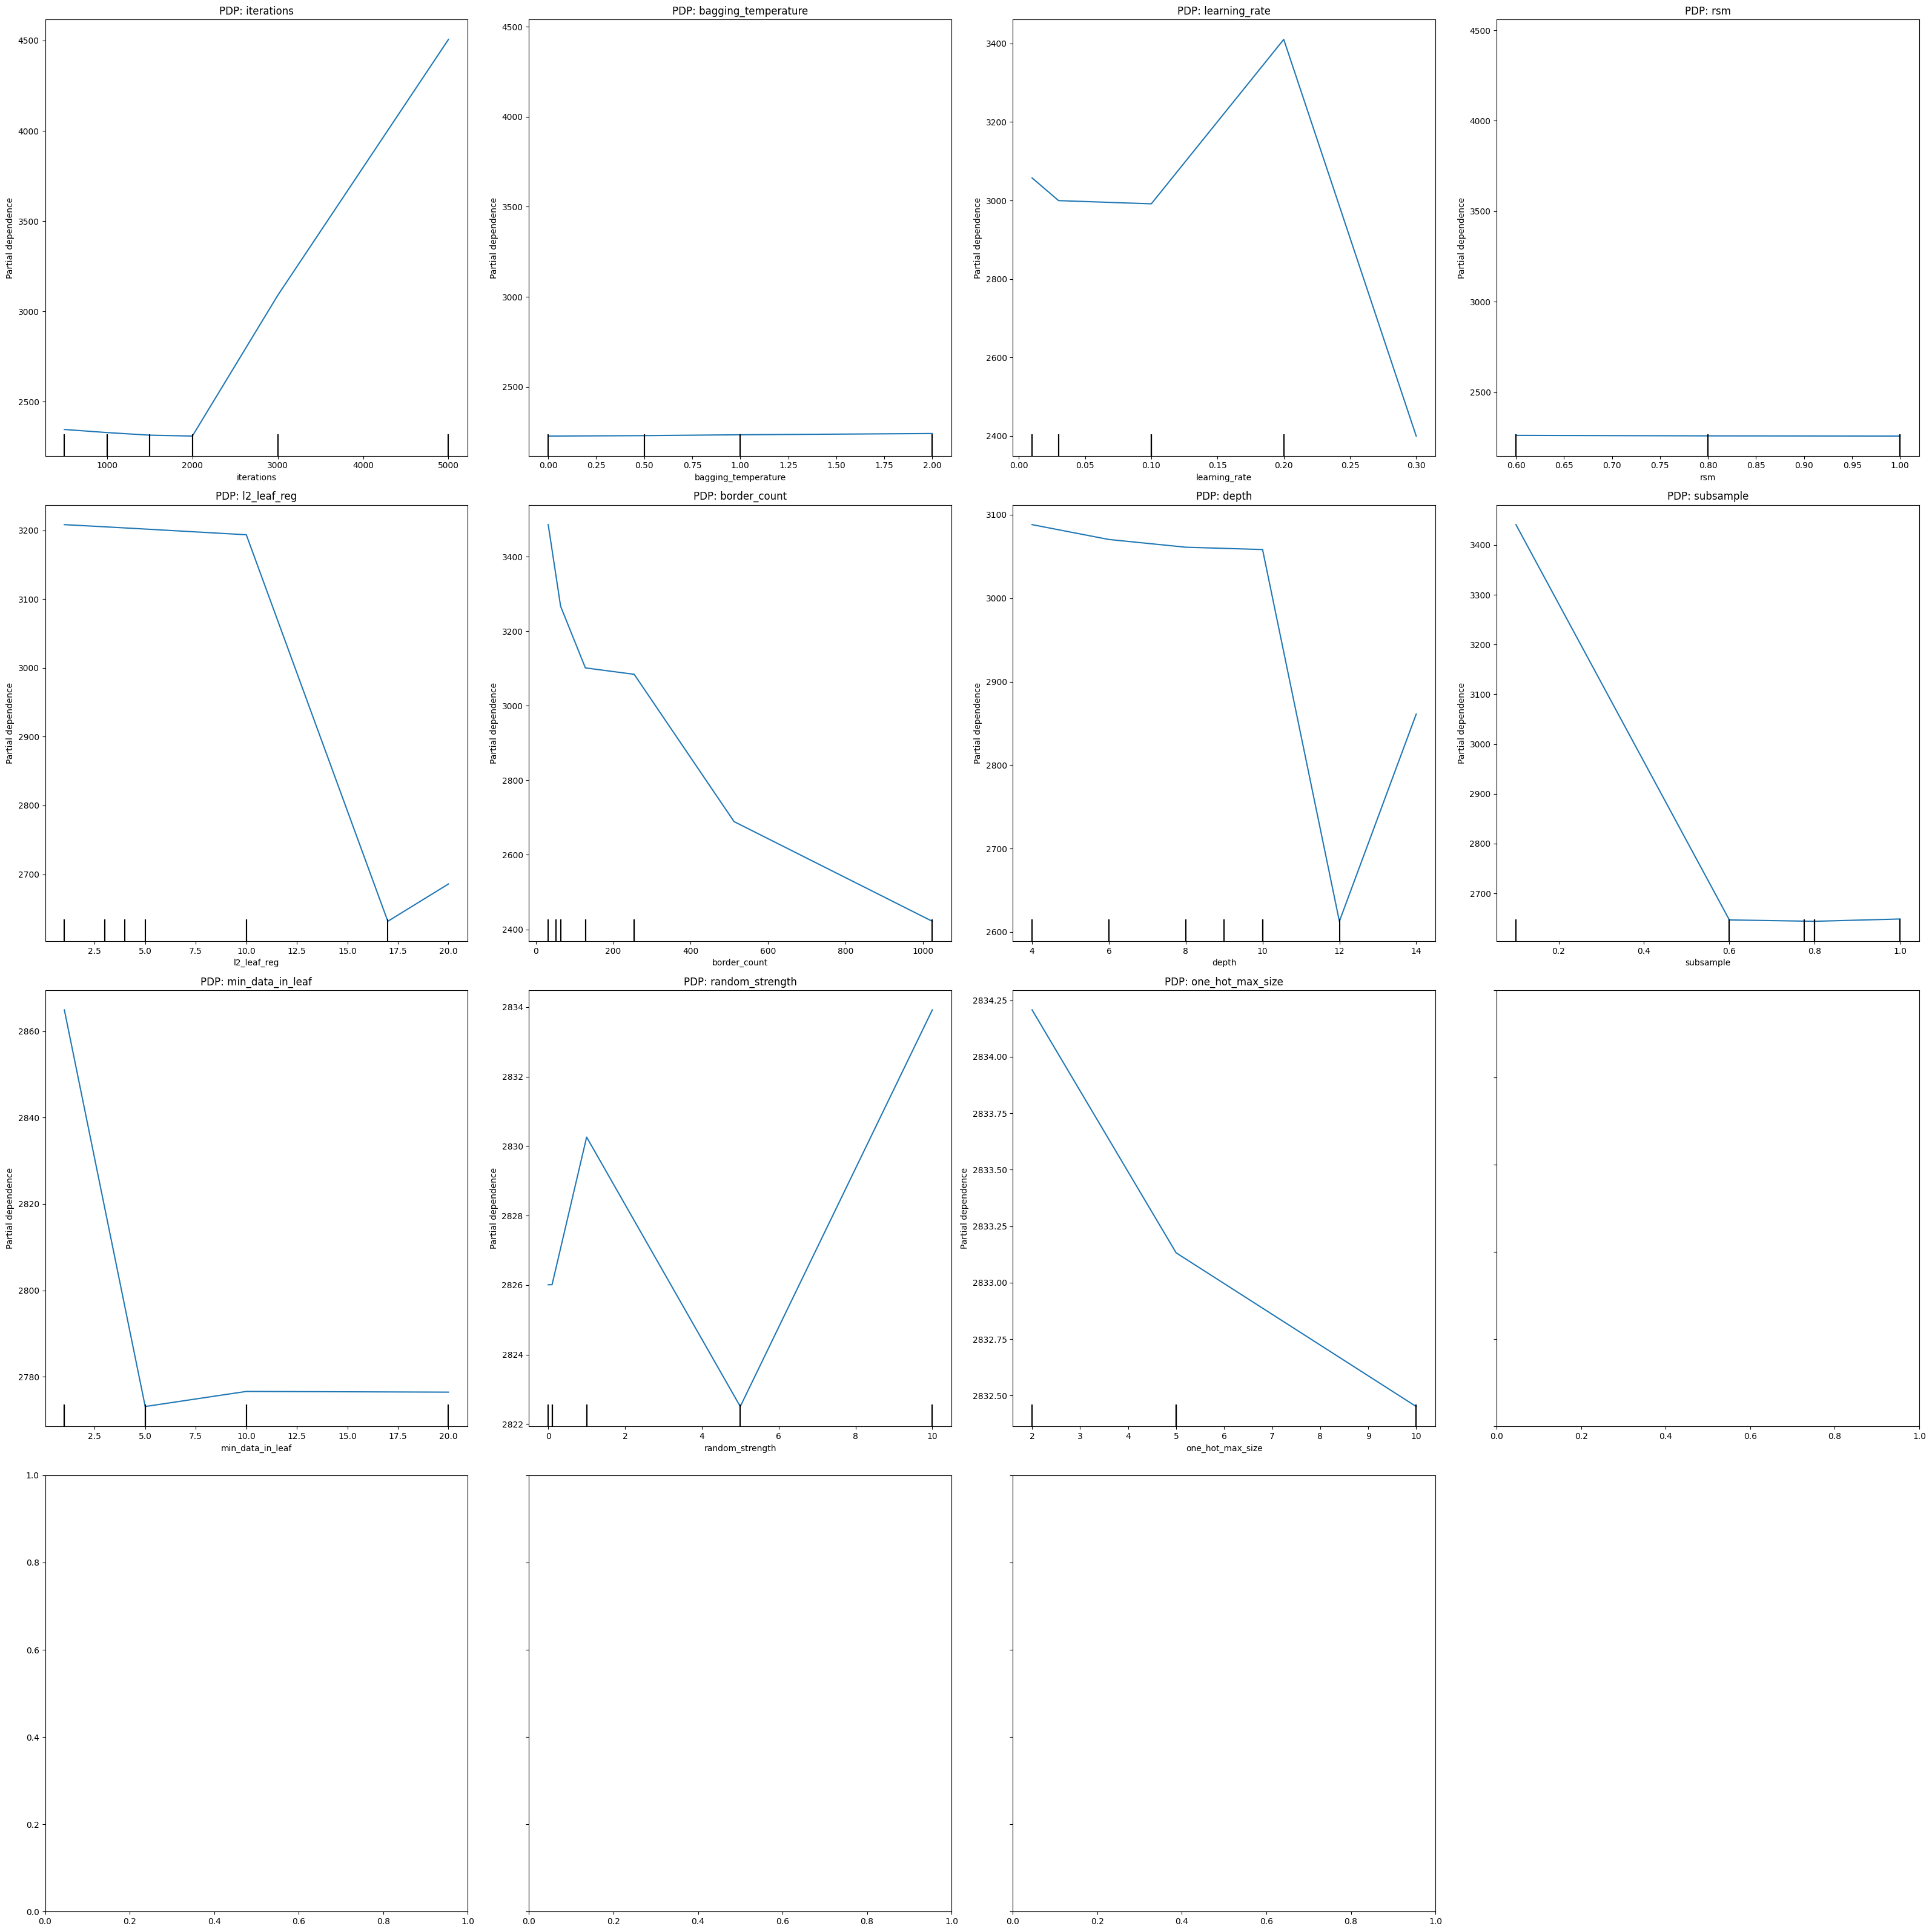

In [224]:
# choose metric & hyper‐param cols, drop any non‐numeric ones —
metric = 'wmae'
ignore = {'model_name','mae','rmse','r2', metric, '__source__'}
param_cols = [c for c in df_all.columns if c not in ignore]

# keep only numeric hyperparams
X = df_all[param_cols].select_dtypes(include=[np.number])
y = df_all[metric]

# train surrogate —
rf = RandomForestRegressor(n_estimators=200, random_state=7, n_jobs=-1)
rf.fit(X, y)

# RF importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("→ RF importances:\n", importances.sort_values(ascending=False), "\n")

# permutation importances
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=7, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns)
print("→ Permutation importances:\n", perm_imp.sort_values(ascending=False), "\n")

# partial dependence plots for top-3 features, all in one figure —
top = importances.sort_values(ascending=False).index[:].tolist()

fig, axes = plt.subplots(4, 4 ,figsize=(32, 32), sharey=True)
axes = axes.flatten()

for ax, feat in zip(axes, top):
    PartialDependenceDisplay.from_estimator(rf, X, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")

# turn off the last (unused) subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
%%skip
#Kaggle
def cat_pipeline_factory(params):
    params = params.copy()
    params.update(
        task_type="GPU",
        devices="0",
        metric_period=20,
        early_stopping_rounds=200,
        bootstrap_type="Bernoulli"      # lets subsample work
    )

    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", CatBoostRegressor(
            **params,
            random_state=7,
            verbose=0
        ))
    ])


param_grid = {
    # core learning-rate / depth / boosting length
    "iterations"        : [2000],
    "depth"             : [12, 16, 20],
    "learning_rate"     : [0.3, 0.4, 0.5],

    # regularisation & tree shape
    "l2_leaf_reg"       : [17,30],
    "min_data_in_leaf"  : [3, 5],
    "random_strength"   : [5],

    # sampling for rows
    "subsample"         : [0.8],        # row sampling now works
    # rsm removed ──↑

    # other structural knobs
    "grow_policy"       : ["Depthwise", "Lossguide"],
    "border_count"      : [1024, 2048, 4096],
    "one_hot_max_size"  : [10,15, 20],

    # objective variants
    "loss_function"     : ["MAE", "RMSE"],
}


trainer = ModelTrainer(
    X               = X_train,
    y               = y_train,
    model_factory   = cat_pipeline_factory,
    search          = "random",
    param_grid      = param_grid,
    n_iter          = 50,
    cv_splitter     = TimeSeriesSplit(n_splits=3),
    custom_metrics  = {"wmae": wmae_custom},
    log_path        = "/kaggle/working/cat_random_wmae02.csv",
    model_name      = "CAT_WMAE",
    problem_type    = "reg",
    n_jobs          = 1,                 # one fit → one GPU
    random_state    = 7
)


best_params, best_score = trainer.train()
print("Best WMAE:", best_score)


trainer.csv_file.close()
del trainer
gc.collect()
